# Data Mining Project

## Context

Market segmentation, the process of identifying customers’ groups, makes use of geographic, demographic, psychographic, and behavioral characteristics of customers. By understanding the differences between the different segments, organizations can make better strategic choices about opportunities, product definition, positioning, promotions, pricing, and target marketing.

A2Z Insurance (A2Z) is a portuguese long standing insurance company that serves a wide array of insurance services: Motor, Household, Health, Life and Work Compensation. Although A2Z primarily serves portuguese customers, a significant portion of their customer acquisition comes from their web site.

In 2016, A2Z became one of the largest insurers in Portugal.and they provided you an ABT (Analytic Based Table) with data regarding a sample of 10.290 Customers from its active database. These are customers that had at least one insurance service with the company at the time the dataset was extracted. 

## Goals
1. Explore the data and identify the variables that should be used to segment customers.
2. Identify customer segments
3. Justify the number of clusters you chose (taking in consideration the business use as well).
4. Explain the clusters found.
5. Suggest business applications for the findings and define general marketing approaches for each cluster.

## Notes

- 2016 is the current year
- Change Name of Columns X
- Fill with 0 the Insurance Premiums X
- Fill with mode Children X
- Fill with median Salary, etc. X
- Deal with Negative Values
- Remove Outliers (IQR Method and Manual) X
- Perform Standardization (MinMaxScaler,Standard Scaler)
- Feature Selection(Check Correlation)
- Create New Variables (Age Group, Income Group, Has Children (Yes/No, Total_Premiums)
- Taking into account that the current year of the database is 2016, we calculated the customer Age , which is 2016 minus birthday year and the Customer_Years is 2016 minus first policy year. Also, i f we divide Customer Monetary Value ( CMV ) by Customer_Years , we obt ain an estimation of the customer Annual_Profit .
- Coherence Checking (Age < 18, Age < Years of Education+4?, Birthday > First_Policy, Negative Salary, Children outside the Ranges, Area different from the range interval
- Clustering by Demographic and Value and Behavior (Data Partition)
- Create new variable Salary Invested Total Premiums/(Salary x 14) x 100

## Importing Libraries

In [1]:
#!pip install -U git+https://github.com/sevamoo/SOMPY.git

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.base import clone
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pandas_profiling import ProfileReport
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver


import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

## Loading Data

In [3]:
df = pd.read_sas('a2z_insurance.sas7bdat')

In [4]:
df['CustID'] = df.CustID.astype(int)

In [5]:
df.set_index('CustID', inplace=True)

## Data Exploration

In [6]:
#Renaming Columns
df.rename(columns={'FirstPolYear':'First_Policy',
                   'EducDeg': 'Education',
                   'MonthSal': 'Salary',
                  'GeoLivArea': 'Area',
                  'CustMonVal': 'CMV',
                   'ClaimsRate': 'Claims',
                  'PremMotor':'Motor',
                  'PremHousehold': 'Household',
                  'PremHealth': 'Health',
                  'PremLife': 'Life',
                  'PremWork': 'Work'}, inplace=True)

In [7]:
df.head()

First_Policy  BirthYear           Education  Salary  Area  Children  \
CustID                                                                        
1             1985.0     1982.0  b'2 - High School'  2177.0   1.0       1.0   
2             1981.0     1995.0  b'2 - High School'   677.0   4.0       1.0   
3             1991.0     1970.0        b'1 - Basic'  2277.0   3.0       0.0   
4             1990.0     1981.0      b'3 - BSc/MSc'  1099.0   4.0       1.0   
5             1986.0     1973.0      b'3 - BSc/MSc'  1763.0   4.0       1.0   

           CMV  Claims   Motor  Household  Health    Life    Work  
CustID                                                             
1       380.97    0.39  375.85      79.45  146.36   47.01   16.89  
2      -131.13    1.12   77.46     416.20  116.69  194.48  106.13  
3       504.67    0.28  206.15     224.50  124.58   86.35   99.02  
4       -16.99    0.99  182.48      43.35  311.17   35.34   28.34  
5        35.23    0.90  338.62      47.80  182.59   18.78   41.45

In [8]:
#Checking Shape of the Dataset
df.shape

(10296, 13)

In [9]:
#Checking all the Columns in the Dataset
df.columns

Index(['First_Policy', 'BirthYear', 'Education', 'Salary', 'Area', 'Children',
       'CMV', 'Claims', 'Motor', 'Household', 'Health', 'Life', 'Work'],
      dtype='object')

In [10]:
df.describe().T

count         mean          std        min      25%      50%  \
First_Policy  10266.0  1991.062634   511.267913    1974.00  1980.00  1986.00   
BirthYear     10279.0  1968.007783    19.709476    1028.00  1953.00  1968.00   
Salary        10260.0  2506.667057  1157.449634     333.00  1706.00  2501.50   
Area          10295.0     2.709859     1.266291       1.00     1.00     3.00   
Children      10275.0     0.706764     0.455268       0.00     0.00     1.00   
CMV           10296.0   177.892605  1945.811505 -165680.42    -9.44   186.87   
Claims        10296.0     0.742772     2.916964       0.00     0.39     0.72   
Motor         10262.0   300.470252   211.914997      -4.11   190.59   298.61   
Household     10296.0   210.431192   352.595984     -75.00    49.45   132.80   
Health        10253.0   171.580833   296.405976      -2.11   111.80   162.81   
Life          10192.0    41.855782    47.480632      -7.00     9.89    25.56   
Work          10210.0    41.277514    51.513572     -12.00    10.67    25.67   

                    75%       max  
First_Policy  1992.0000  53784.00  
BirthYear     1983.0000   2001.00  
Salary        3290.2500  55215.00  
Area             4.0000      4.00  
Children         1.0000      1.00  
CMV            399.7775  11875.89  
Claims           0.9800    256.20  
Motor          408.3000  11604.42  
Household      290.0500  25048.80  
Health         219.8200  28272.00  
Life            57.7900    398.30  
Work            56.7900   1988.70

In [11]:
#Checking information for all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10296 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   First_Policy  10266 non-null  float64
 1   BirthYear     10279 non-null  float64
 2   Education     10279 non-null  object 
 3   Salary        10260 non-null  float64
 4   Area          10295 non-null  float64
 5   Children      10275 non-null  float64
 6   CMV           10296 non-null  float64
 7   Claims        10296 non-null  float64
 8   Motor         10262 non-null  float64
 9   Household     10296 non-null  float64
 10  Health        10253 non-null  float64
 11  Life          10192 non-null  float64
 12  Work          10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [12]:
#Checking if there is any Null value present in the Dataset?
df.isnull().sum()

First_Policy     30
BirthYear        17
Education        17
Salary           36
Area              1
Children         21
CMV               0
Claims            0
Motor            34
Household         0
Health           43
Life            104
Work             86
dtype: int64

In [13]:
### Percentage of Missing Data
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

column_name  percent_missing
First_Policy  First_Policy         0.291375
BirthYear        BirthYear         0.165113
Education        Education         0.165113
Salary              Salary         0.349650
Area                  Area         0.009713
Children          Children         0.203963
CMV                    CMV         0.000000
Claims              Claims         0.000000
Motor                Motor         0.330225
Household        Household         0.000000
Health              Health         0.417638
Life                  Life         1.010101
Work                  Work         0.835276

## Data Preparation

### Handling Missing Values

In [14]:
df['First_Policy'].median()

1986.0

In [15]:
df['First_Policy'].fillna(df['First_Policy'].median(), inplace=True)

In [16]:
df['BirthYear'].median()

1968.0

In [17]:
df['BirthYear'].fillna(df['BirthYear'].median(), inplace=True)

In [18]:
df['Education'].mode()[0]

b'3 - BSc/MSc'

In [19]:
df['Education'].fillna(df['Education'].mode()[0], inplace=True)

In [20]:
df['Salary'].median()

2501.5

In [21]:
df['Salary'].fillna(df['Salary'].median(), inplace=True)

In [22]:
df['Area'].median()

3.0

In [23]:
df['Area'].fillna(df['Area'].median(), inplace=True)

In [24]:
#We assume that Nan means that they don't have kids
df['Children'].fillna(0, inplace=True)

In [25]:
df['Motor'].fillna(0, inplace=True)
df['Health'].fillna(0, inplace=True)
df['Life'].fillna(0, inplace=True)
df['Work'].fillna(0, inplace=True)

In [26]:
df.isnull().sum()

First_Policy    0
BirthYear       0
Education       0
Salary          0
Area            0
Children        0
CMV             0
Claims          0
Motor           0
Household       0
Health          0
Life            0
Work            0
dtype: int64

In [27]:
df['First_Policy'] = df['First_Policy'].astype(int)
df['BirthYear'] = df['BirthYear'].astype(int)
df['Area'] = df['Area'].astype(int)
df['Children'] = df['Children'].astype(int)

## Notes:

## Handling Outliers

In [28]:
#Define metric and non-metric features. Why?
non_metric_features = ["Education", "Area", "Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

In [29]:
# let's keep the central imputation
df_copy = df.copy()

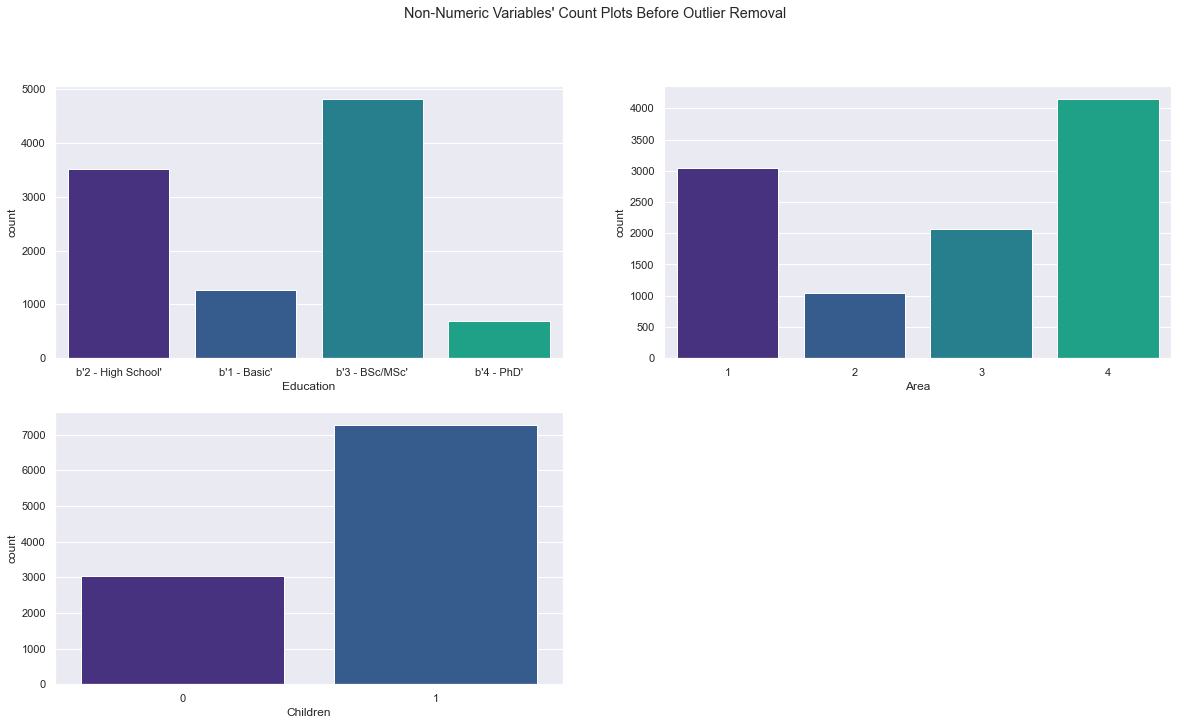

In [30]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat], ax=ax, palette=sns.color_palette('viridis'), saturation=1)
    
fig.delaxes(axes[1,1])
# Layout
# Add a centered title to the figure:
title = "Non-Numeric Variables' Count Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

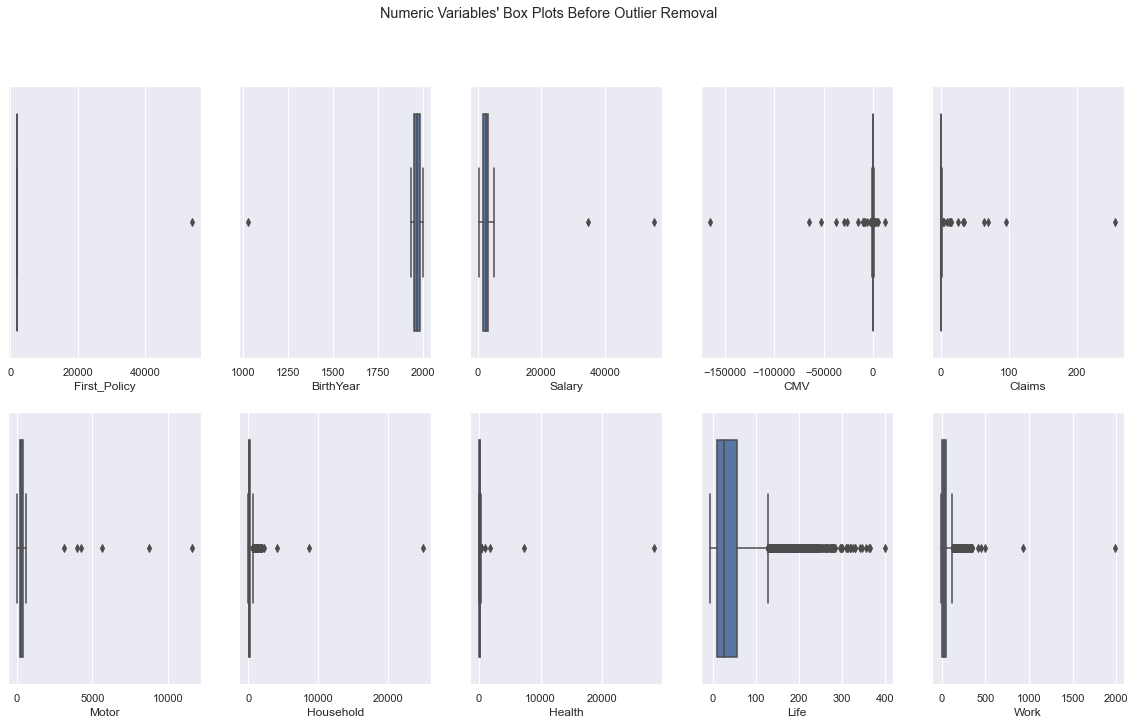

In [31]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

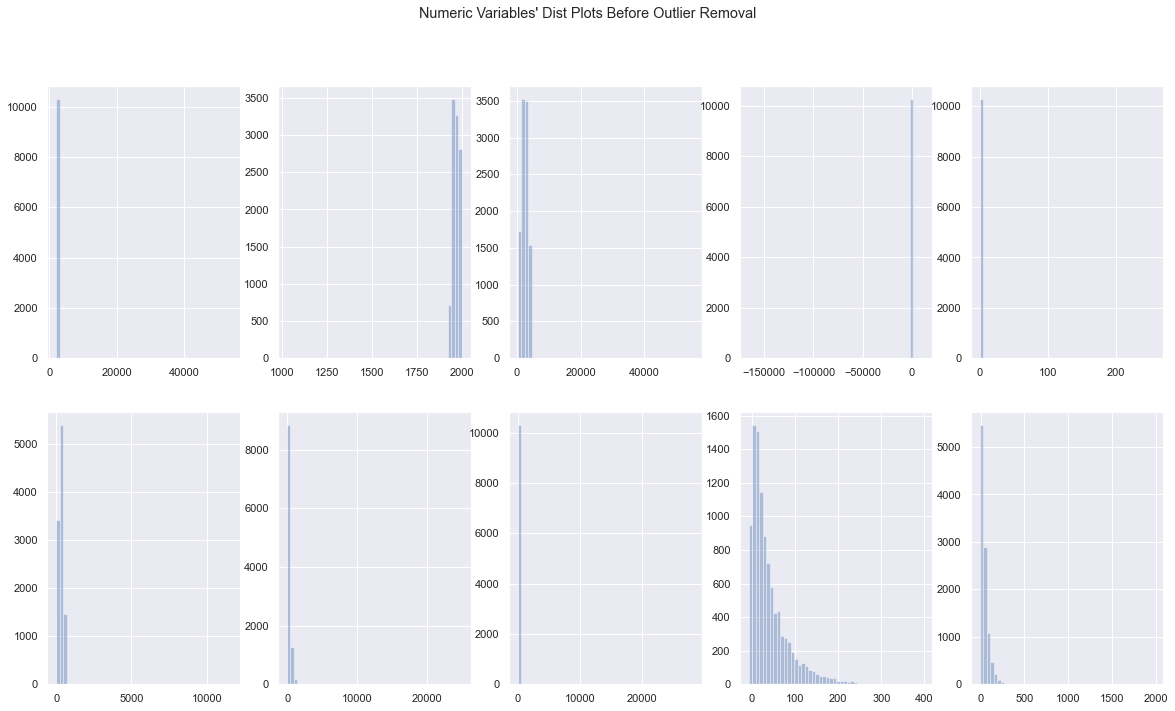

In [32]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.distplot(x=df[feat], ax=ax, kde=False)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Dist Plots Before Outlier Removal"

plt.suptitle(title)

plt.show()

### Manual method

In [33]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['BirthYear'] > 1800)
    &
    (df['First_Policy'] < 20000)
    &
    (df['Salary'] <= 5000)
    &
    (df['CMV'] <= 1000) & (df['CMV'] > -1500)
    &
    (df['Claims'] <= 4)
    &
    (df['Motor'] <= 1500)
    &
    (df['Household'] <= 500)
    &
    (df['Health'] <= 400)
    &
    (df['Life'] <= 100)
    &
    (df['Work'] <= 100)
)

df_1 = df_copy[filters1]

In [34]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.777


### IQR method

In [35]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df_copy[metric].between(llim, ulim, inclusive='both'))
    print(f" {metric} , {round(llim,2)}, {round(ulim,2)}")

df_2 = df[np.all(filters2,0)]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

 First_Policy , 1962.0, 2010.0
 BirthYear , 1908.0, 2028.0
 Salary , -662.25, 5659.75
 CMV , -623.27, 1013.6
 Claims , -0.5, 1.86
 Motor , -135.63, 733.41
 Household , -311.45, 650.95
 Health , -51.16, 381.03
 Life , -60.79, 127.69
 Work , -59.02, 125.02
Percentage of data kept after removing outliers: 0.8555


In [36]:
df_3 = df_copy[(filters1 | np.all(filters2,0))]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.8568


In [37]:
#Applying it to the DataFrame
df = df[(filters1 | np.all(filters2,0))]

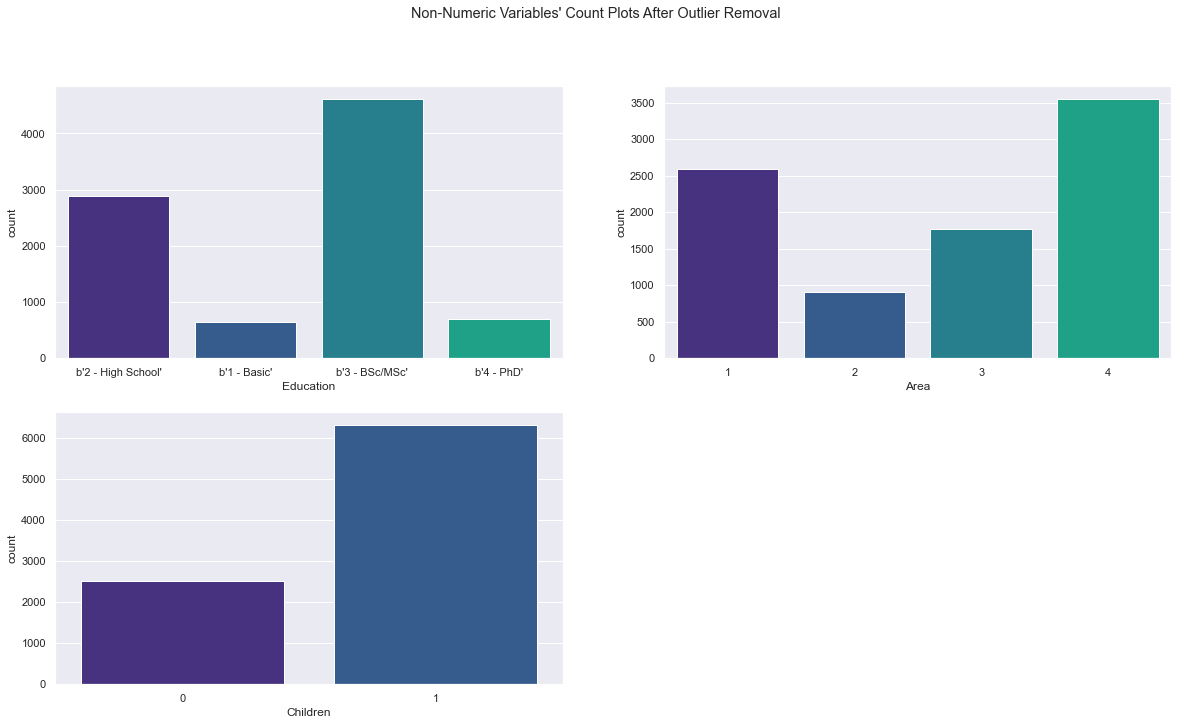

In [38]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat], ax=ax, palette=sns.color_palette('viridis'), saturation=1)
    
fig.delaxes(axes[1,1])
# Layout
# Add a centered title to the figure:
title = "Non-Numeric Variables' Count Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

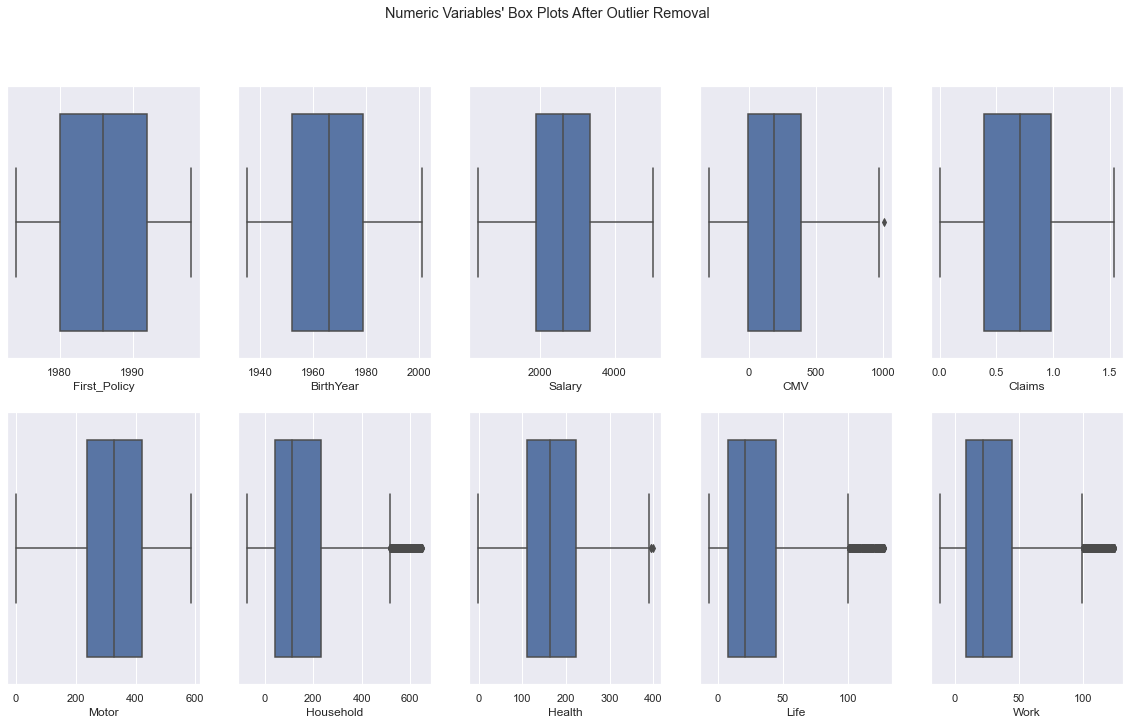

In [39]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

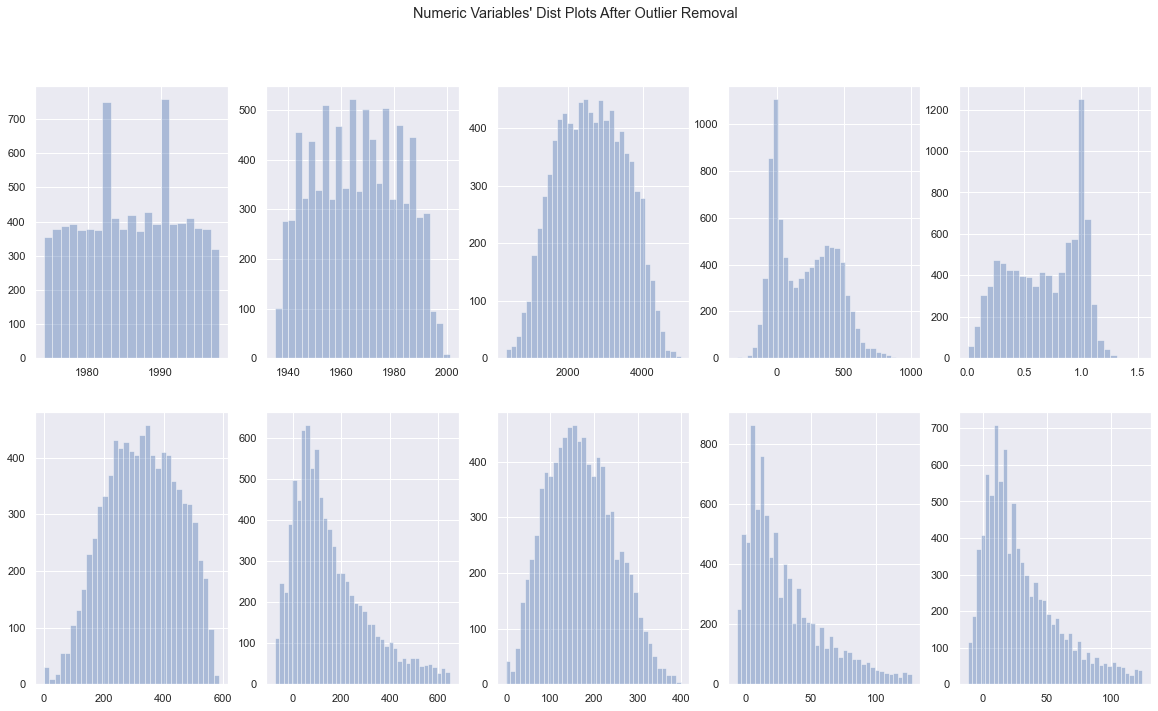

In [40]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.distplot(x=df[feat], ax=ax, kde=False)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Dist Plots After Outlier Removal"

plt.suptitle(title)

plt.show()

## Data Preprocessing

### List
- Age X
- Customer Years (Loyalty years) X
- Total Premium X
- Customer Annual Profit X
- Salary Invested Total Premiums/(Salary x 14) x 100 X
- Change Education

## Questions
Minimum Age and Customer Years for insurance?
<br>
Group By age?
<br>
Should we remove negative values from premiums?
<br>
Customer Monetary Value (CMV) can be negative?

In [41]:
#Age of Customer
df['Age'] = 2016 - df['BirthYear']

In [42]:
#Number of Years of Loyalty
df['Customer_Years'] = 2016 - df['First_Policy']

In [43]:
#Removing negative values because customers no longer possess that kind of premium
df['Work'][df['Work']<=0] = 0
df['Life'][df['Life']<=0] = 0
df['Health'][df['Health']<=0] = 0
df['Motor'][df['Motor'] <= 0] = 0
df['Household'][df['Household'] <= 0] = 0

In [44]:
#Summing All premiums
df['Total_Premium'] = df['Work'] + df['Life'] + df['Health'] + df['Motor'] + df['Household']

In [45]:
#Annually Rate of Salary Invested in Premiums
df['Salary_Rate'] = (df['Total_Premium'] / (df['Salary'] * 14)) * 100

In [46]:
def binary_education(x):
    """Function that receives values for Education and assigns their ranking(1,2,3,4)"""
    if x == b'1 - Basic':
        return 1
    elif x == b'2 - High School':
        return 2
    elif x == b'3 - BSc/MSc':
        return 3
    elif x == b'4 - PhD':
        return 4

In [47]:
#Transformin Categorical Variable into Ordinal Variable (Ranking Education)
df['Education'] = df['Education'].apply(lambda x : binary_education(x))

In [48]:
df.head()

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
1               1985       1982          2  2177.0     1         1  380.97   
3               1991       1970          1  2277.0     3         0  504.67   
4               1990       1981          3  1099.0     4         1  -16.99   
5               1986       1973          3  1763.0     4         1   35.23   
6               1986       1956          2  2566.0     4         1  -24.33   

        Claims   Motor  Household  Health   Life   Work  Age  Customer_Years  \
CustID                                                                         
1         0.39  375.85      79.45  146.36  47.01  16.89   34              31   
3         0.28  206.15     224.50  124.58  86.35  99.02   46              25   
4         0.99  182.48      43.35  311.17  35.34  28.34   35              26   
5         0.90  338.62      47.80  182.59  18.78  41.45   43              30   
6         1.00  440.75      18.90  114.80   7.00   7.67   60              30   

        Total_Premium  Salary_Rate  
CustID                              
1              665.56     2.183739  
3              740.60     2.323232  
4              600.68     3.904069  
5              629.24     2.549388  
6              589.12     1.639906

## Coherence Checking

#Generally speaking, the minimum age of entry for life insurance plans like term plans and whole life plans is 18 years.
#The maximum age of entry ranges from 65 to 69 years, depending on the type of plan and insurer.

In [49]:
#age - customer_years >= 0 == #customer_years > age
indexAge = df[df['Customer_Years'] - df['Age'] >= 0].index
df[df['Customer_Years'] - df['Age'] >= 0]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
19              1981       1982          1  1414.0     3         1  230.38   
21              1986       1986          4  1704.0     4         1  373.73   
23              1976       1986          2  1495.0     1         1  -89.79   
47              1976       1986          3  1219.0     4         1  -94.90   
72              1985       1989          3  1159.0     4         1  195.82   
...              ...        ...        ...     ...   ...       ...     ...   
10228           1977       1990          3  1177.0     1         1  -40.78   
10232           1976       1997          2  1140.0     3         0  249.95   
10260           1975       1985          2  1882.0     1         1  467.31   
10268           1977       1996          1   834.0     4         1  254.72   
10285           1980       1987          3  1504.0     4         1   -1.55   

        Claims   Motor  Household  Health    Life   Work  Age  Customer_Years  \
CustID                                                                          
19        0.71  313.17     373.40  121.80   14.78  72.57   34              35   
21        0.39  329.84      65.00  221.93    3.89  33.34   30              30   
23        1.08  209.04     308.95  192.48   64.79  54.90   30              40   
47        1.08  269.94     300.60  143.25   59.79  69.90   30              40   
72        0.72  150.03     236.70  286.61   70.79  33.23   27              31   
...        ...     ...        ...     ...     ...    ...  ...             ...   
10228     1.03  379.96      48.90  190.48    0.00   1.78   26              39   
10232     0.55  327.73      23.90  178.81   21.56  55.12   19              40   
10260     0.30  320.17     157.25  170.70   37.34  22.45   31              41   
10268     0.67  181.48     309.50  134.58  114.80  98.24   20              39   
10285     0.96  390.63      29.45  179.70    0.00   0.00   29              36   

        Total_Premium  Salary_Rate  
CustID                              
19             895.72     4.524752  
21             654.00     2.741449  
23             830.16     3.966364  
47             843.48     4.942459  
72             777.36     4.790830  
...               ...          ...  
10228          621.12     3.769389  
10232          607.12     3.804010  
10260          707.91     2.686769  
10268          838.60     7.182254  
10285          599.78     2.848499  

[1289 rows x 17 columns]

In [50]:
# age <= 18 has children
df[(df['Age'] <= 18) & (df['Children'] == 1)]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
1447            1997       1999          1   388.0     4         1  798.49   
2147            1977       1998          1  1195.0     4         1  334.83   
2607            1992       1998          1   566.0     1         1   97.91   
3374            1988       1998          1   482.0     4         1  -81.90   
3996            1989       1998          2  1250.0     1         1  117.25   
4317            1998       1999          1   876.0     2         1  102.47   
4995            1984       1998          2   564.0     4         1   79.13   
5348            1980       2001          1  1119.0     3         1  796.71   
5544            1988       1998          2  1726.0     4         1  -21.22   
5967            1979       1998          1   838.0     4         1   74.24   
7956            1980       1998          1   774.0     1         1  -25.00   
8170            1988       1998          1   711.0     3         1  305.29   
8836            1985       1998          2   773.0     1         1  518.31   
9458            1976       1998          2   614.0     1         1  -32.00   
9459            1995       1999          1   962.0     1         1  333.19   
9481            1983       1998          2  1323.0     3         1  387.07   
10207           1996       1998          1   794.0     4         1  655.46   

        Claims   Motor  Household  Health    Life    Work  Age  \
CustID                                                           
1447      0.25   60.90     637.90  275.83   48.12   76.57   17   
2147      0.59  362.18     310.60  106.13   46.23   49.23   18   
2607      0.84  102.02     230.05  337.84   58.01   37.12   18   
3374      1.06  103.24     362.85  280.83   48.23  105.13   18   
3996      0.85   34.34     428.40  287.72  107.91   98.35   18   
4317      0.88  127.47     564.00  147.25   66.68  115.80   17   
4995      0.90  125.58     511.75  165.81  104.13   98.13   18   
5348      0.23  148.14     628.45  221.82   45.12   30.23   15   
5544      1.00  102.13     585.10  201.37   85.35   89.13   18   
5967      0.91   72.79     604.00  193.37  116.80   99.24   18   
7956      1.00   66.79     568.45  236.71   72.57  101.24   18   
8170      0.61  141.47     298.95  255.27   32.34  110.13   18   
8836      0.50   40.23     605.10  272.05   61.79  110.91   18   
9458      1.01   97.13     511.20  261.16   44.23  104.13   18   
9459      0.62  180.81     416.20  192.48   58.01   92.46   17   
9481      0.50  112.02     300.05  287.50   47.01   77.57   18   
10207     0.32   56.90     515.65  260.16  102.02   62.79   18   

        Customer_Years  Total_Premium  Salary_Rate  
CustID                                              
1447                19        1099.32    20.237850  
2147                39         874.37     5.226360  
2607                24         765.04     9.654720  
3374                28         900.28    13.341434  
3996                27         956.72     5.466971  
4317                18        1021.20     8.326810  
4995                32        1005.40    12.733029  
5348                36        1073.76     6.854079  
5544                28        1063.08     4.399437  
5967                37        1086.20     9.258438  
7956                36        1045.76     9.650794  
8170                28         838.16     8.420334  
8836                31        1090.08    10.072815  
9458                40        1017.85    11.840973  
9459                21         939.96     6.979210  
9481                33         824.15     4.449573  
10207               20         997.52     8.973732

In [51]:
#Age > Education [Basic == 1] + [High School == 2] + [BSc/MSc <= 3] + [PhD <= 4]
df[(df['Age'] <= 25) & (df['Education'] == 4)]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
710             1986       1991          4   689.0     1         1  -30.89   
818             1982       1992          4  1541.0     4         1  640.57   
1264            1996       1991          4  1118.0     3         1    3.79   
2169            1989       1991          4  1372.0     1         1  485.21   
3108            1992       1992          4  1261.0     1         1  298.95   
3261            1978       1992          4  1654.0     1         1  288.17   
4123            1982       1993          4  1900.0     1         1   16.01   
5238            1984       1993          4  1374.0     4         1  -37.89   
8085            1994       1993          4   971.0     4         1  476.19   
8359            1984       1993          4  1797.0     1         1  -69.32   
8870            1991       1992          4  1602.0     1         1  -36.78   

        Claims   Motor  Household  Health   Life   Work  Age  Customer_Years  \
CustID                                                                         
710       1.01  212.93     147.80  294.50  28.56  34.45   25              30   
818       0.00  329.73      83.35  222.93   6.89  22.67   24              34   
1264      0.95  363.18      38.35  174.59   1.89   7.67   25              20   
2169      0.29  287.50     176.70  186.59  12.78  58.79   25              27   
3108      0.53  314.06     138.35  216.82  13.67   9.89   24              24   
3261      0.52  276.72      93.35  210.93  41.34  36.45   24              38   
4123      0.94  333.73      87.80  170.70  21.56  19.45   23              34   
5238      1.02  509.65      70.00   72.57  12.89   2.89   23              32   
8085      0.33  297.61     158.35  223.82  19.67  45.23   23              22   
8359      1.08  488.87       0.00   86.46   7.89   8.89   23              32   
8870      1.02  408.30       3.90  129.58  11.78  32.56   24              25   

        Total_Premium  Salary_Rate  
CustID                              
710            718.24     7.445988  
818            665.57     3.085056  
1264           585.68     3.741886  
2169           722.36     3.760725  
3108           692.79     3.924266  
3261           658.79     2.845008  
4123           633.24     2.380602  
5238           668.00     3.472655  
8085           744.68     5.478005  
8359           592.11     2.353565  
8870           586.12     2.613340

What Is the Minimum Age for Getting a PhD? To get a PhD, you have to have graduated from undergraduate school. From there, some people can go right into a PhD program. If you graduate at the traditional age of 22, you'd be getting your PhD somewhere around age 25 at a minimum

In [52]:
df[(df['Age'] <= 20) & (df['Education'] == 3)]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
382             1977       1996          3  1165.0     4         1  570.10   
984             1994       1996          3  1320.0     3         1  562.90   
1527            1977       1996          3  1152.0     1         1  259.50   
1617            1981       1996          3  1548.0     1         1  283.40   
2661            1981       1996          3  1548.0     1         1  -84.79   
2993            1992       1996          3  1842.0     4         1  340.30   
6483            1997       1996          3  1382.0     1         1  -54.67   
7896            1984       1996          3  1378.0     4         0   84.14   

        Claims   Motor  Household  Health    Life    Work  Age  \
CustID                                                           
382       0.45  183.59      595.1  135.58  121.80   48.90   20   
984       0.44   84.24      587.9  268.94    2.00  106.24   20   
1527      0.63  206.04      236.7  257.16   25.56   52.90   20   
1617      0.55  240.60      136.7  140.47   59.79  111.91   20   
2661      1.10  240.60      136.7  140.47   59.79    0.00   20   
2993      0.41  178.59       67.8  258.05   72.57   46.34   20   
6483      1.03   89.24      587.9  228.82  118.91   11.56   20   
7896      0.84  161.03      136.7  313.06   27.56   53.01   20   

        Customer_Years  Total_Premium  Salary_Rate  
CustID                                              
382                 39        1084.97     6.652177  
984                 22        1049.32     5.678139  
1527                39         778.36     4.826141  
1617                35         689.47     3.181386  
2661                35         577.56     2.665006  
2993                24         623.35     2.417210  
6483                19        1036.43     5.356781  
7896                32         691.36     3.583662

In [53]:
df[(df['Age'] <= 18) & (df['Education'] == 2)]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
3996            1989       1998          2  1250.0     1         1  117.25   
4995            1984       1998          2   564.0     4         1   79.13   
5544            1988       1998          2  1726.0     4         1  -21.22   
7252            1993       1998          2  1133.0     4         0  400.74   
7917            1992       1998          2  1207.0     3         0  574.12   
8836            1985       1998          2   773.0     1         1  518.31   
9458            1976       1998          2   614.0     1         1  -32.00   
9481            1983       1998          2  1323.0     3         1  387.07   
9634            1986       1998          2  1067.0     1         0  652.12   

        Claims   Motor  Household  Health    Life    Work  Age  \
CustID                                                           
3996      0.85   34.34     428.40  287.72  107.91   98.35   18   
4995      0.90  125.58     511.75  165.81  104.13   98.13   18   
5544      1.00  102.13     585.10  201.37   85.35   89.13   18   
7252      0.52   56.79     368.95  298.39   96.24   70.79   18   
7917      0.41   97.13     549.00  243.38   50.12   67.57   18   
8836      0.50   40.23     605.10  272.05   61.79  110.91   18   
9458      1.01   97.13     511.20  261.16   44.23  104.13   18   
9481      0.50  112.02     300.05  287.50   47.01   77.57   18   
9634      0.29  101.02     457.30  179.70  126.69   93.13   18   

        Customer_Years  Total_Premium  Salary_Rate  
CustID                                              
3996                27         956.72     5.466971  
4995                32        1005.40    12.733029  
5544                28        1063.08     4.399437  
7252                23         891.16     5.618207  
7917                24        1007.20     5.960469  
8836                31        1090.08    10.072815  
9458                40        1017.85    11.840973  
9481                33         824.15     4.449573  
9634                30         957.84     6.412103

In [54]:
df[(df['Age'] <= 18) & (df['Education'] == 1)]

First_Policy  BirthYear  Education  Salary  Area  Children     CMV  \
CustID                                                                       
1447            1997       1999          1   388.0     4         1  798.49   
2147            1977       1998          1  1195.0     4         1  334.83   
2580            1986       2001          1  1006.0     4         0  267.95   
2607            1992       1998          1   566.0     1         1   97.91   
3374            1988       1998          1   482.0     4         1  -81.90   
4317            1998       1999          1   876.0     2         1  102.47   
5348            1980       2001          1  1119.0     3         1  796.71   
5967            1979       1998          1   838.0     4         1   74.24   
7405            1997       2000          1   865.0     1         0  472.97   
7956            1980       1998          1   774.0     1         1  -25.00   
8170            1988       1998          1   711.0     3         1  305.29   
9009            1988       1999          1   844.0     4         0 -142.69   
9048            1986       1999          1  1214.0     3         0  129.47   
9459            1995       1999          1   962.0     1         1  333.19   
9637            1992       2000          1  1001.0     4         0  704.35   
9709            1979       1998          1   738.0     4         0  423.53   
10207           1996       1998          1   794.0     4         1  655.46   

        Claims   Motor  Household  Health    Life    Work  Age  \
CustID                                                           
1447      0.25   60.90     637.90  275.83   48.12   76.57   17   
2147      0.59  362.18     310.60  106.13   46.23   49.23   18   
2580      0.67   48.23     396.75  291.50  127.58   24.45   15   
2607      0.84  102.02     230.05  337.84   58.01   37.12   18   
3374      1.06  103.24     362.85  280.83   48.23  105.13   18   
4317      0.88  127.47     564.00  147.25   66.68  115.80   17   
5348      0.23  148.14     628.45  221.82   45.12   30.23   15   
5967      0.91   72.79     604.00  193.37  116.80   99.24   18   
7405      0.42   62.68     330.05  283.61   83.46  105.24   16   
7956      1.00   66.79     568.45  236.71   72.57  101.24   18   
8170      0.61  141.47     298.95  255.27   32.34  110.13   18   
9009      1.12   41.12     526.20  272.83  122.69   36.12   17   
9048      0.80  111.02     221.15  263.16   92.35   85.35   17   
9459      0.62  180.81     416.20  192.48   58.01   92.46   17   
9637      0.31   43.34     570.10  241.49   87.24  115.91   16   
9709      0.39  402.41     186.70   64.79   32.45   46.12   18   
10207     0.32   56.90     515.65  260.16  102.02   62.79   18   

        Customer_Years  Total_Premium  Salary_Rate  
CustID                                              
1447                19        1099.32    20.237850  
2147                39         874.37     5.226360  
2580                30         888.51     6.308648  
2607                24         765.04     9.654720  
3374                28         900.28    13.341434  
4317                18        1021.20     8.326810  
5348                36        1073.76     6.854079  
5967                37        1086.20     9.258438  
7405                19         865.04     7.143187  
7956                36        1045.76     9.650794  
8170                28         838.16     8.420334  
9009                28         998.96     8.454299  
9048                30         773.03     4.548305  
9459                21         939.96     6.979210  
9637                24        1058.08     7.550164  
9709                37         732.47     7.089334  
10207               20         997.52     8.973732

In [55]:
# delete all rows with column 'Age' has value 30 to 40
df.drop(indexAge, inplace=True)
#df.head(15)

## Data Partition
- Demographic (Age, Salary, Area, Education, Children)
- Insurance (Work, Life, Health, Household, Motor)

In [56]:
demo_df = pd.DataFrame(df, columns=['BirthYear','Age', 'Education', 'Salary', 'Area','Children'])

In [57]:
demo_df.head()

BirthYear  Age  Education  Salary  Area  Children
CustID                                                   
1            1982   34          2  2177.0     1         1
3            1970   46          1  2277.0     3         0
4            1981   35          3  1099.0     4         1
5            1973   43          3  1763.0     4         1
6            1956   60          2  2566.0     4         1

In [58]:
insurance_df = pd.DataFrame(df, columns=['First_Policy', 'CMV', 'Claims', 'Motor', 'Household',
                                         'Life', 'Health', 'Work', 'Customer_Years', 'Total_Premium', 'Salary_Rate'])

In [59]:
insurance_df.head()

First_Policy     CMV  Claims   Motor  Household   Life  Health   Work  \
CustID                                                                          
1               1985  380.97    0.39  375.85      79.45  47.01  146.36  16.89   
3               1991  504.67    0.28  206.15     224.50  86.35  124.58  99.02   
4               1990  -16.99    0.99  182.48      43.35  35.34  311.17  28.34   
5               1986   35.23    0.90  338.62      47.80  18.78  182.59  41.45   
6               1986  -24.33    1.00  440.75      18.90   7.00  114.80   7.67   

        Customer_Years  Total_Premium  Salary_Rate  
CustID                                              
1                   31         665.56     2.183739  
3                   25         740.60     2.323232  
4                   26         600.68     3.904069  
5                   30         629.24     2.549388  
6                   30         589.12     1.639906

## Feature Selection

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FA02A30BE0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FA02A30BE0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


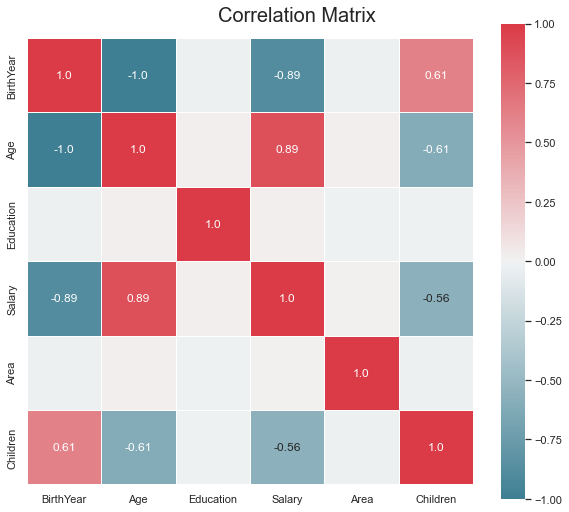

In [60]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(demo_df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FA030D3610>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FA030D3610> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


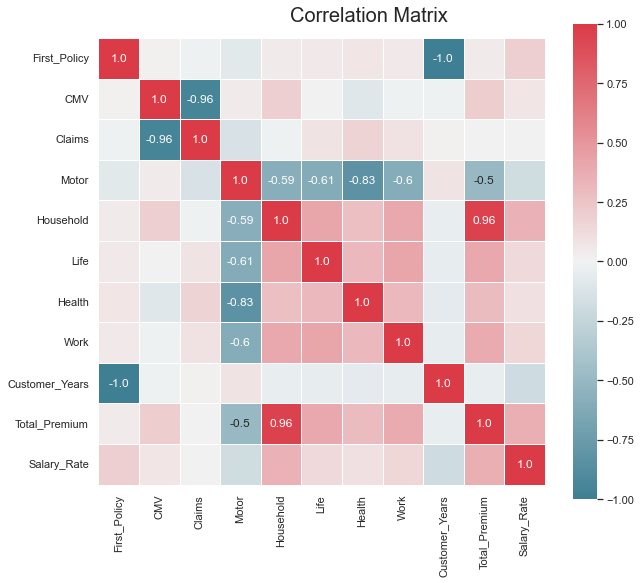

In [61]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(insurance_df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

## Insights

<h4>Demo DataFrame</h4>
<ul>
<li>Age vs BirthYear</li>
<li>Salary vs BirthYear</li>
<li>Age vs Salary</li>
</ul>

<h4>Insurance DataFrame</h4>
<ul>
<li>Household vs Total_Premium</li>
<li>Claims vs CMV</li>
</ul>

We decided to drop Age, BirthYear, Claims, Total_Premium

In [62]:
demo_df.drop(['BirthYear','Age'], axis=1, inplace=True)

In [63]:
insurance_df.drop(['First_Policy', 'Total_Premium', 'Claims'], axis=1, inplace=True)

## Data Standardization/Normalization

<h4>Standart Scaler</h4>
<ul>
    <li>It works well at outlier detection.</li>
    <li>Features need to be the same type. If one feature represents count and one represents length, that will cause a negative effect on data.</li>
    <li>Normalizing your data will scale most of your data to a small interval if you have outliers in your feature.</li>

<h4>MinMax Scaler</h4>
<ul>
<li>It preserves the shape of the original distribution.</li>
<li>The default range for the feature returned by MinMaxScaler is 0 to 1.</li>
<li>The importance of outlier values doesn’t affect, so those can be used for outlier detection algorithms.</li>
 </ul>

<h4>Robust Scaler</h4>
<ul>
<li>There is no default range to scale the data like MinMax Scaler.</li>
<li>It doesn’t work well for outlier detection.</li>
<li>It reduces the effects of outliers.</li>
<li>Value range is interquartile range (Quartile 1 to Quartile 3)</li>
</ul>

In [64]:
demo_non_metric_features = []
demo_metric_features = demo_df.columns.drop(non_metric_features).to_list()

In [65]:
demo_df_scaled = StandardScaler().fit_transform(demo_df[demo_metric_features])
demo_df[demo_metric_features] = demo_df_scaled
demo_df_scaled

array([[-0.76774144],
       [-0.64686041],
       [-2.07083892],
       ...,
       [ 0.12798698],
       [-1.01675636],
       [ 0.00347952]])

In [66]:
demo_df.head()

Education    Salary  Area  Children
CustID                                     
1               2 -0.767741     1         1
3               1 -0.646860     3         0
4               3 -2.070839     4         1
5               3 -1.268189     4         1
6               2 -0.297514     4         1

In [67]:
demo_df_minmax = MinMaxScaler().fit_transform(demo_df)
demo_df_minmax

array([[0.33333333, 0.37971647, 0.        , 1.        ],
       [0.        , 0.40152672, 0.66666667, 0.        ],
       [0.66666667, 0.14460196, 1.        , 1.        ],
       ...,
       [0.66666667, 0.54133043, 0.        , 1.        ],
       [0.        , 0.33478735, 0.33333333, 1.        ],
       [1.        , 0.51886587, 0.        , 1.        ]])

In [68]:
demo_df_robust = RobustScaler().fit_transform(demo_df)
demo_df_robust

array([[-1.        , -0.51881505, -0.66666667,  0.        ],
       [-2.        , -0.438751  ,  0.        , -1.        ],
       [ 0.        , -1.38190552,  0.33333333,  0.        ],
       ...,
       [ 0.        ,  0.07445957, -0.66666667,  0.        ],
       [-2.        , -0.683747  , -0.33333333,  0.        ],
       [ 1.        , -0.00800641, -0.66666667,  0.        ]])

In [69]:
insurance_df_scaled = StandardScaler().fit_transform(insurance_df)
insurance_df_scaled

array([[ 8.01632838e-01,  2.99532843e-01, -4.64697967e-01, ...,
        -4.20623136e-01,  2.80711799e-01,  2.10227944e-01],
       [ 1.35835449e+00, -1.13619004e+00,  5.63163590e-01, ...,
         2.59608402e+00, -6.45256081e-01,  3.64528372e-01],
       [-9.89417675e-01, -1.33644674e+00, -7.20511840e-01, ...,
        -5.45623981e-05, -4.90928101e-01,  2.11317033e+00],
       ...,
       [ 1.44580074e+00,  5.34561610e-01, -8.66461639e-02, ...,
        -8.61393694e-01, -1.10824002e+00, -3.20105289e-01],
       [ 2.12417004e-01, -1.28475394e+00,  4.68562061e-01, ...,
         3.10627594e+00,  8.98023719e-01,  9.01076715e-01],
       [ 1.17419079e+00,  6.22972359e-01, -3.58404114e-01, ...,
        -5.67546655e-01, -4.90928101e-01, -3.26010789e-01]])

In [70]:
insurance_df_minmax = MinMaxScaler().fit_transform(insurance_df)
insurance_df_minmax

array([[0.52196077, 0.64223711, 0.12241911, ..., 0.13533654, 0.54166667,
        0.16416341],
       [0.61692833, 0.35226069, 0.3459168 , ..., 0.79342949, 0.29166667,
        0.17464986],
       [0.21643699, 0.31181436, 0.06679507, ..., 0.22708333, 0.33333333,
        0.29348983],
       ...,
       [0.63184523, 0.68970644, 0.2046225 , ..., 0.03918269, 0.16666667,
        0.12812128],
       [0.42145023, 0.32225488, 0.32534669, ..., 0.90472756, 0.70833333,
        0.21111438],
       [0.58551303, 0.70756297, 0.14553159, ..., 0.10328526, 0.33333333,
        0.12771993]])

In [71]:
insurance_df_robust = RobustScaler().fit_transform(insurance_df)
insurance_df_robust

array([[ 0.4809011 ,  0.17515924, -0.13743531, ..., -0.08442886,
         0.2       ,  0.52578618],
       [ 0.78712712, -0.7408507 ,  0.69666475, ...,  2.31492843,
        -0.4       ,  0.70162128],
       [-0.50427033, -0.86861708, -0.34502588, ...,  0.25007304,
        -0.3       ,  2.69430944],
       ...,
       [ 0.83522713,  0.32511066,  0.1693502 , ..., -0.43499854,
        -0.7       , -0.0785621 ],
       [ 0.15680158, -0.8356364 ,  0.61989649, ...,  2.72071283,
         0.6       ,  1.31305207],
       [ 0.68582745,  0.38151787, -0.05117884, ..., -0.20128542,
        -0.3       , -0.08529179]])

## Insights

After evaluating the differente methods we decided to go with StandardScaler because the use of it brings more advantages 

## Dimensionality Reduction

In [72]:
df_pca = insurance_df.copy()

In [73]:
features = list(insurance_df.columns)

In [74]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca)
pca_feat  # What is this output?

array([[ 1.61875251e+02, -9.69103598e+01, -4.14997815e+01, ...,
        -9.78890436e+00,  1.84661299e+00,  3.49174196e-01],
       [ 3.15183843e+02,  9.67771877e+01, -4.12743015e+01, ...,
        -7.46362884e+00, -3.50503278e+00,  1.25379413e-01],
       [-2.35726672e+02,  1.04538970e+02, -1.97646746e+02, ...,
         7.15388850e+00, -2.48782021e+00,  2.13688953e+00],
       ...,
       [ 3.11881207e+02, -1.02845682e+02, -6.96209303e+00, ...,
         4.93876215e+00, -7.28464896e+00, -4.54027800e-01],
       [ 6.14875410e+01,  1.55805793e+02, -6.34182345e+01, ...,
        -2.31871039e+01,  6.57304845e+00,  7.65875373e-01],
       [ 2.45153087e+02, -1.27626424e+02, -1.87110150e+01, ...,
         2.01279333e+00, -3.33872025e+00, -2.89701565e-01]])

In [75]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue    Difference  Proportion  Cumulative
1  50550.319174      0.000000    0.558717    0.558717
2  29201.609723 -21348.709452    0.322756    0.881473
3   8710.421921 -20491.187802    0.096274    0.977747
4   1309.652340  -7400.769581    0.014475    0.992222
5    440.276487   -869.375853    0.004866    0.997088
6    221.062272   -219.214215    0.002443    0.999531
7     41.719532   -179.342740    0.000461    0.999992
8      0.682112    -41.037420    0.000008    1.000000

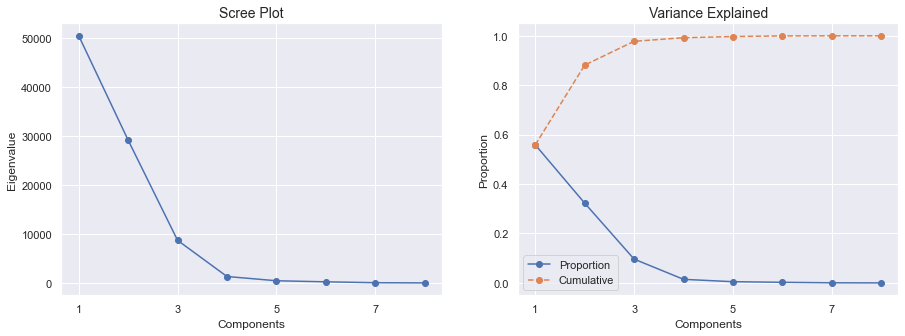

In [76]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [77]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0         PC1         PC2         PC3
CustID                                                
1       161.875251  -96.910360  -41.499782   11.860037
3       315.183843   96.777188  -41.274301  120.969480
4      -235.726672  104.538970 -197.646746  -18.461164
5      -183.540424  -36.213159  -54.454433    3.636761
6      -248.042896 -136.037849   23.542877   -5.243229
...            ...         ...         ...         ...
10290    68.705944  161.583428   16.760343   70.767589
10292  -218.835789  -70.301427  -14.508447  -27.877187
10294   311.881207 -102.845682   -6.962093  -23.692837
10295    61.487541  155.805793  -63.418234   74.044249
10296   245.153087 -127.626424  -18.711015  -20.211695

[7533 rows x 4 columns]

In [78]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

CMV   Motor  Household   Life  Health   Work  Customer_Years  \
CustID                                                                    
1       380.97  375.85      79.45  47.01  146.36  16.89              31   
3       504.67  206.15     224.50  86.35  124.58  99.02              25   
4       -16.99  182.48      43.35  35.34  311.17  28.34              26   
5        35.23  338.62      47.80  18.78  182.59  41.45              30   
6       -24.33  440.75      18.90   7.00  114.80   7.67              30   

        Salary_Rate         PC0         PC1         PC2         PC3  
CustID                                                               
1          2.183739  161.875251  -96.910360  -41.499782   11.860037  
3          2.323232  315.183843   96.777188  -41.274301  120.969480  
4          3.904069 -235.726672  104.538970 -197.646746  -18.461164  
5          2.549388 -183.540424  -36.213159  -54.454433    3.636761  
6          1.639906 -248.042896 -136.037849   23.542877   -5.243229

In [79]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[features + pca_feat_names].corr().loc[features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [80]:
insurance_df = df_pca.copy()

In [81]:
insurance_df.head()

CMV   Motor  Household   Life  Health   Work  Customer_Years  \
CustID                                                                    
1       380.97  375.85      79.45  47.01  146.36  16.89              31   
3       504.67  206.15     224.50  86.35  124.58  99.02              25   
4       -16.99  182.48      43.35  35.34  311.17  28.34              26   
5        35.23  338.62      47.80  18.78  182.59  41.45              30   
6       -24.33  440.75      18.90   7.00  114.80   7.67              30   

        Salary_Rate         PC0         PC1         PC2         PC3  
CustID                                                               
1          2.183739  161.875251  -96.910360  -41.499782   11.860037  
3          2.323232  315.183843   96.777188  -41.274301  120.969480  
4          3.904069 -235.726672  104.538970 -197.646746  -18.461164  
5          2.549388 -183.540424  -36.213159  -54.454433    3.636761  
6          1.639906 -248.042896 -136.037849   23.542877   -5.243229

In [82]:
# Do this after checking the new pandas profiling report
insurance_df.drop(columns=['PC2'], inplace=True)

In [83]:
#ProfileReport(
#    df,
#    title='A2Z Insurance Data',
#    correlations={
#        "pearson": {"calculate": True},
#        "spearman": {"calculate": False},
#        "kendall": {"calculate": False},
#        "phi_k": {"calculate": False},
#        "cramers": {"calculate": False},
#    },
#)

## Data Clustering
Hierarchical Clustering, SOM (Self Organizing Maps), K-means, t-SNE

In [84]:
pc_features = insurance_df.columns[insurance_df.columns.str.startswith('PC')]

In [85]:
df.head()
df.drop(['First_Policy','BirthYear','Claims','Age', 'Total_Premium'], inplace=True, axis=1)

In [86]:
df_non_metric_features = []
df_metric_features = df.columns.drop(non_metric_features).to_list() 

In [87]:
df_scaled = StandardScaler().fit_transform(df[df_metric_features])
df[df_metric_features] = df_scaled
df_scaled

array([[-7.67741438e-01,  8.01632838e-01,  2.99532843e-01, ...,
        -4.20623136e-01,  2.80711799e-01,  2.10227944e-01],
       [-6.46860410e-01,  1.35835449e+00, -1.13619004e+00, ...,
         2.59608402e+00, -6.45256081e-01,  3.64528372e-01],
       [-2.07083892e+00, -9.89417675e-01, -1.33644674e+00, ...,
        -5.45623981e-05, -4.90928101e-01,  2.11317033e+00],
       ...,
       [ 1.27986981e-01,  1.44580074e+00,  5.34561610e-01, ...,
        -8.61393694e-01, -1.10824002e+00, -3.20105289e-01],
       [-1.01675636e+00,  2.12417004e-01, -1.28475394e+00, ...,
         3.10627594e+00,  8.98023719e-01,  9.01076715e-01],
       [ 3.47952180e-03,  1.17419079e+00,  6.22972359e-01, ...,
        -5.67546655e-01, -4.90928101e-01, -3.26010789e-01]])

### K-means

In [88]:
kmclust = KMeans(n_clusters=8, init='random', n_init=10, random_state=1)
# the fit method
kmclust.fit(df[df_metric_features])

KMeans(init='random', random_state=1)

In [89]:
# the predict method
kmclust.predict(df[df_metric_features])

array([2, 4, 2, ..., 0, 4, 0])

In [90]:
# the transform method
pd.DataFrame(kmclust.transform(df[df_metric_features]))

0         1         2         3         4         5         6  \
0     1.889784  4.202251  1.765711  2.607634  3.265424  2.304396  3.456003   
1     5.011235  3.951328  4.181876  5.588949  2.844358  4.595789  3.126441   
2     5.408159  2.912767  2.809956  4.989722  4.483401  4.721497  5.074720   
3     3.070833  3.700513  1.294769  2.432556  3.144925  2.711144  4.068194   
4     2.259002  5.545015  2.596961  0.493215  4.119183  2.612872  4.809990   
...        ...       ...       ...       ...       ...       ...       ...   
7528  4.898642  4.676134  4.231951  5.004067  1.771457  3.478670  2.306345   
7529  2.552610  5.513502  2.683749  1.476979  3.460344  1.709057  4.238563   
7530  1.572285  5.186466  2.676423  2.922971  4.232699  3.102938  3.844102   
7531  5.441107  3.566461  4.053048  5.538075  2.646643  4.236604  3.529488   
7532  0.982774  5.150456  2.408965  2.402583  3.986360  2.601567  3.881701   

             7  
0     2.924811  
1     4.553289  
2     4.474354  
3     3.012334  
4     2.986373  
...        ...  
7528  3.517547  
7529  2.098672  
7530  2.727865  
7531  4.681094  
7532  2.611700  

[7533 rows x 8 columns]

In [91]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[df_metric_features])

KMeans(n_init=15, random_state=1)

In [92]:
kmclust.predict(df[df_metric_features])

array([4, 3, 4, ..., 0, 3, 0])

### Defining Number of Clusters

In [93]:
range_clusters = range(1, 11)

In [94]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[df_metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

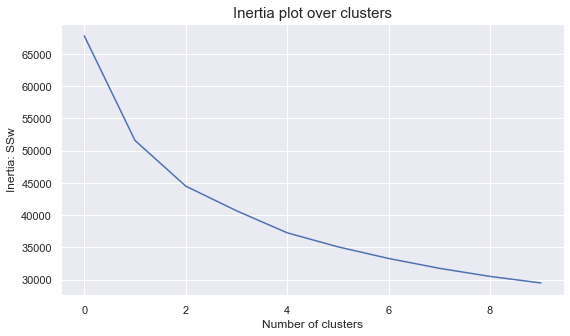

In [95]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.23179155905976842
For n_clusters = 3, the average silhouette_score is : 0.23002690577111706
For n_clusters = 4, the average silhouette_score is : 0.17192997220992903
For n_clusters = 5, the average silhouette_score is : 0.17124355938440117
For n_clusters = 6, the average silhouette_score is : 0.1691693960582699
For n_clusters = 7, the average silhouette_score is : 0.16940438070003092
For n_clusters = 8, the average silhouette_score is : 0.16708540155659482
For n_clusters = 9, the average silhouette_score is : 0.16043080809981425
For n_clusters = 10, the average silhouette_score is : 0.16103765448836382


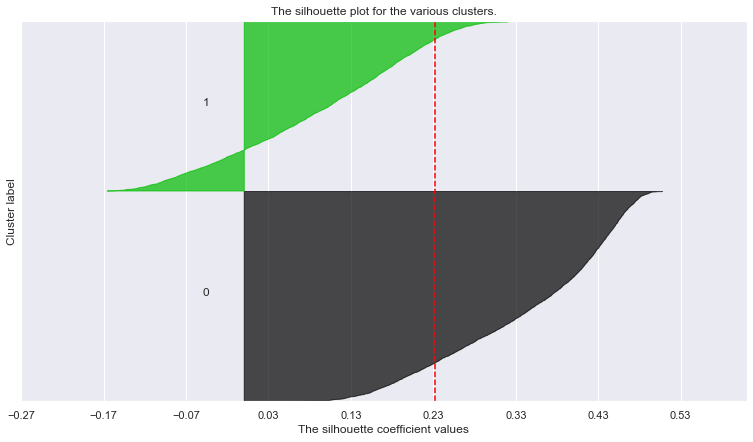

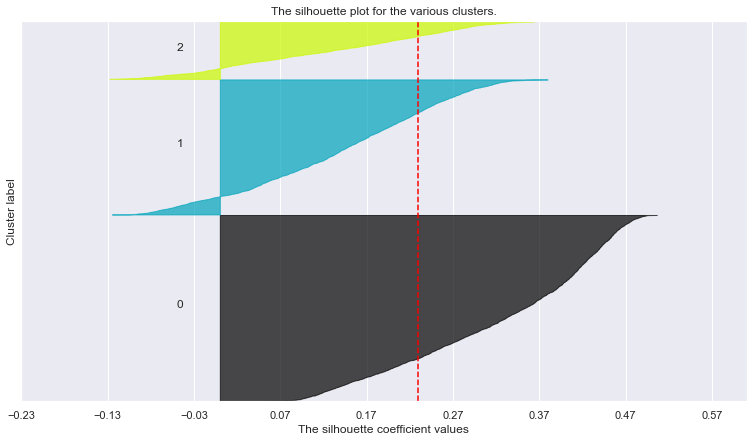

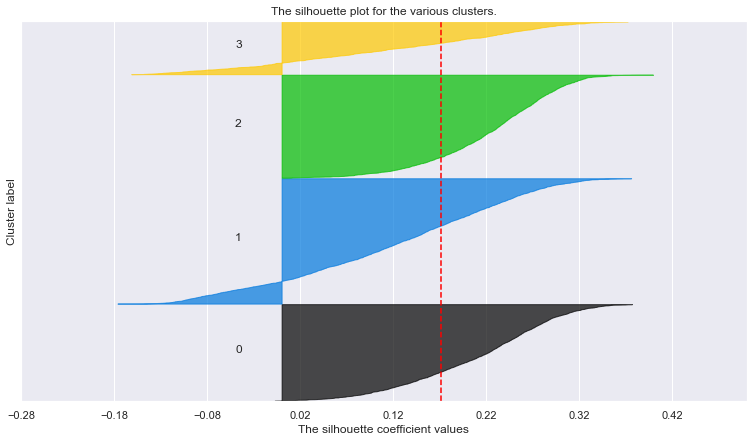

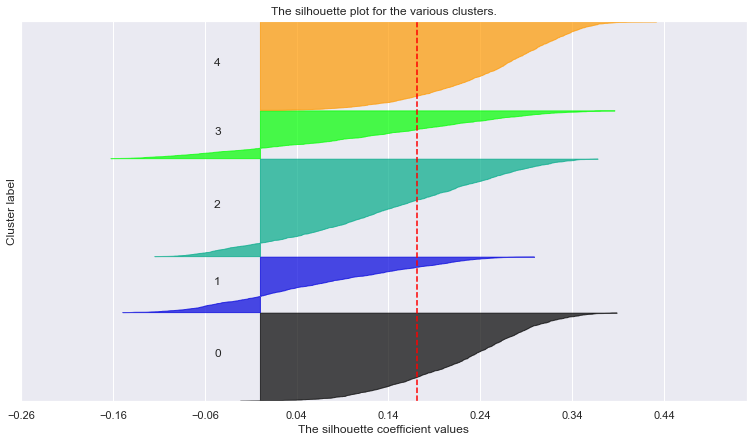

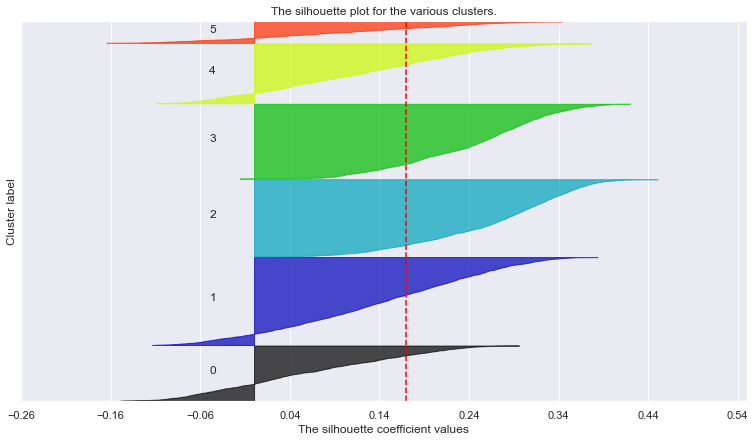

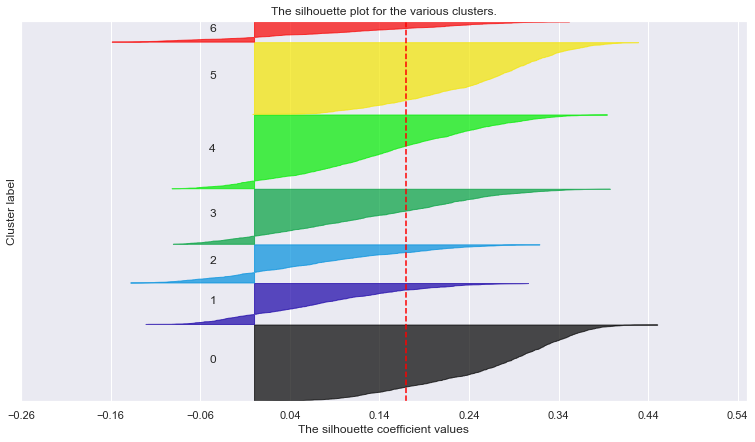

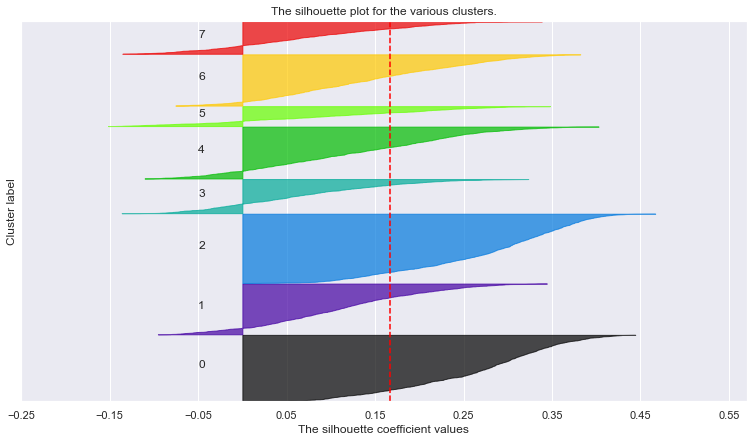

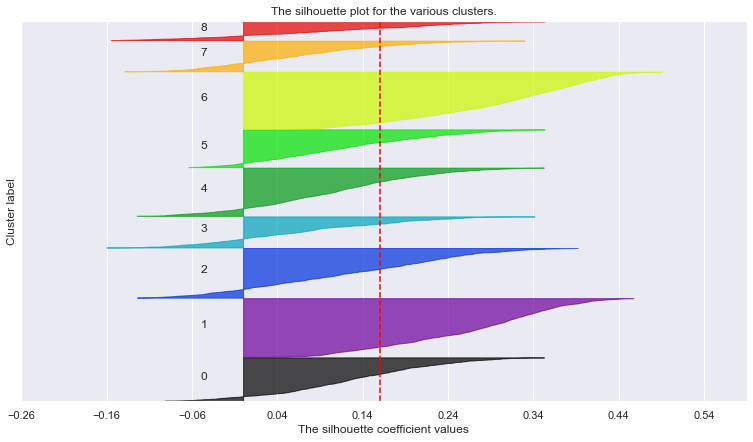

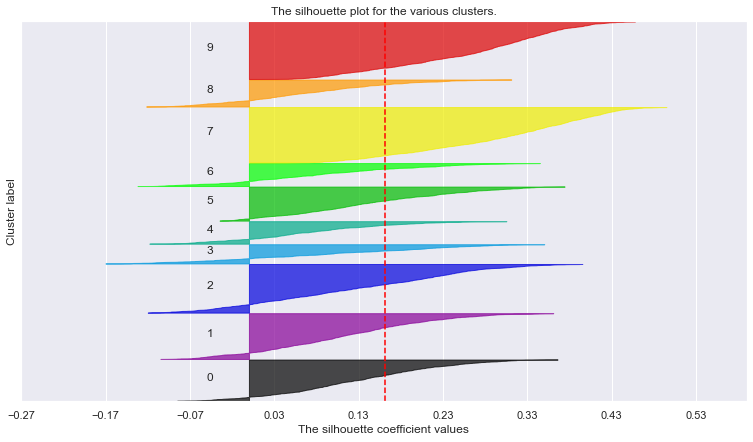

In [96]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[df_metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[df_metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[df_metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[df_metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

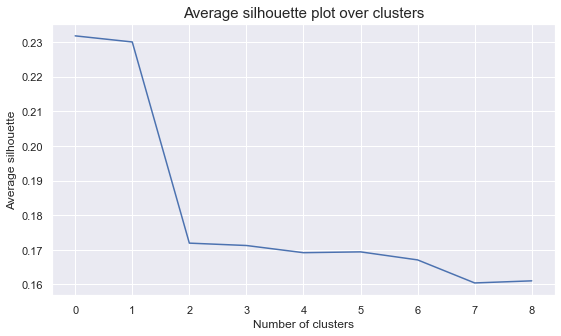

In [97]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final K-means clustering solution

In [98]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[df_metric_features])
km_labels

array([0, 2, 2, ..., 0, 2, 0])

In [99]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

Education    Salary      Area  Children       CMV     Motor  \
labels                                                                
0.0      2.611747  0.002881  2.701884  0.683044 -0.009297  0.008539   
1.0      2.608782 -0.008817  2.706587  0.685130  0.008083 -0.014806   
2.0      2.657679  0.023627  2.717468  0.676436  0.017494  0.010321   

        Household    Health      Life      Work  Customer_Years  Salary_Rate  
labels                                                                        
0.0     -0.006943 -0.013639  0.015544  0.006908       -0.011012    -0.006238  
1.0      0.006395  0.015725 -0.007635 -0.020739       -0.001607     0.022817  
2.0     -0.024075  0.000479 -0.023052 -0.002037       -0.004786    -0.039918

### Self-Organizing-Maps (SOM)

In [100]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[df_metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.044000, quantization error: 2.979399

 epoch: 2 ---> elapsed time:  0.037000, quantization error: 2.801840

 epoch: 3 ---> elapsed time:  0.039000, quantization error: 2.743664

 epoch: 4 ---> elapsed time:  0.038000, quantization error: 2.696301

 epoch: 5 ---> elapsed time:  0.038000, quantization error: 2.680590

 epoch: 6 ---> elapsed time:  0.037000, quantization error: 2.671735

 epoch: 7 ---> elapsed time:  0.038000, quantization error: 2.664445

 epoch: 8 ---> elapsed time:  0.039000, quantization error: 2.658065

 epoch: 9 ---> elapsed time:  0.037000, quantization error: 2.651476

 epoch: 10 ---> elapsed time:  0.037000, quantization error: 2.644593

 epoch: 11 ---> elapsed time:  0.037000, quantization error: 2.638190

 epoch: 12 ---> elapsed time:  0.037000, quantization error: 2.633427

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.035000, quantization error: 1.713437

 epoch: 15 ---> elapsed time:  0.035000, quantization error: 1.713076

 epoch: 16 ---> elapsed time:  0.035000, quantization error: 1.712891

 epoch: 17 ---> elapsed time:  0.036000, quantization error: 1.712580

 epoch: 18 ---> elapsed time:  0.035000, quantization error: 1.712488

 epoch: 19 ---> elapsed time:  0.035000, quantization error: 1.712264

 epoch: 20 ---> elapsed time:  0.035000, quantization error: 1.712130

 epoch: 21 ---> elapsed time:  0.035000, quantization error: 1.712009

 epoch: 22 ---> elapsed time:  0.036000, quantization error: 1.711786

 epoch: 23 ---> elapsed time:  0.036000, quantization error: 1.711527

 epoch: 24 ---> elapsed time:  0.035000, quantization error: 1.711374

 epoch: 25 ---> elapsed time:  0.036000, quantization error: 1.711248

 epoch: 26 ---> elapsed time:  0.036000, quantization error: 1.711109

 epoch: 27 ---> elapsed time:  0.036000, quantization error: 1.710943

 epoch

In [101]:
plt.rcParams['figure.dpi'] = 72

In [102]:
weights = sm.codebook.matrix 

In [103]:
###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(df_metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

In [104]:
print("matplotlib version is:" , mplver)

matplotlib version is: 3.4.3


### Component Planes

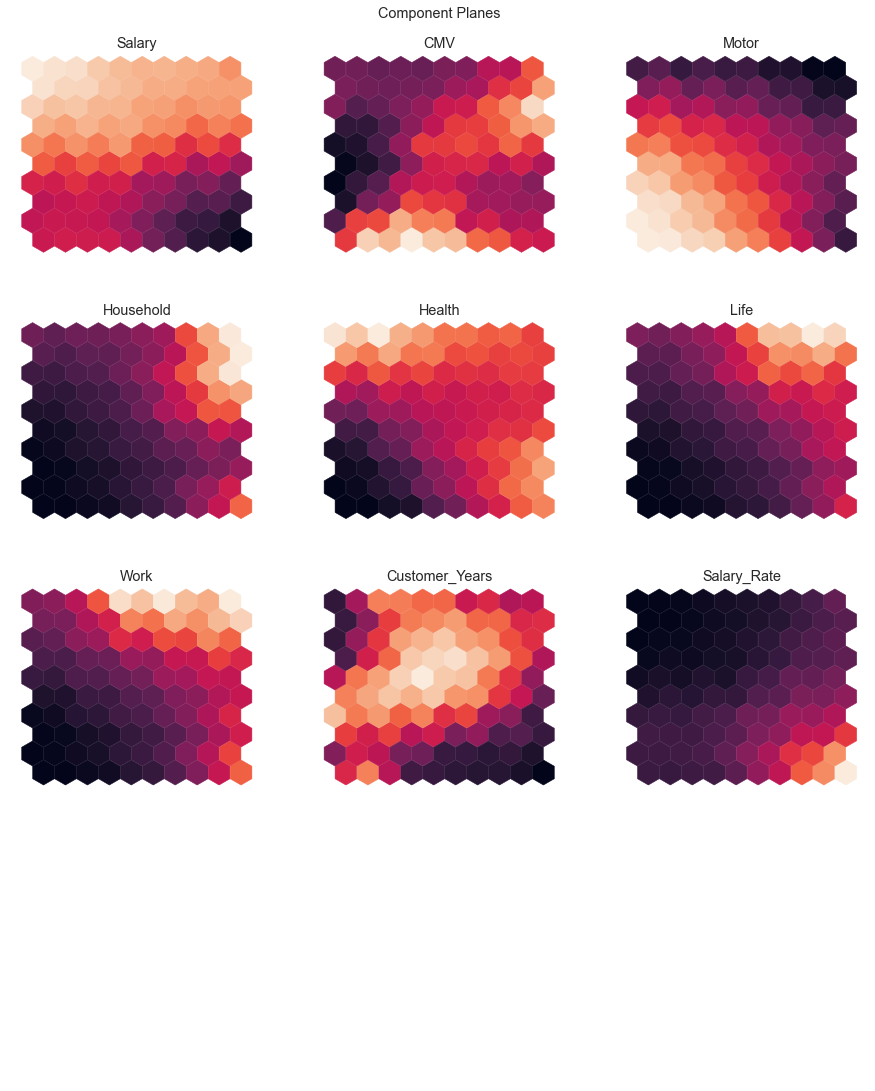

In [105]:
#### Use this if cell below does not work ####

plot_component_planes(weights=sm.codebook.matrix,features=df_metric_features,
                      M=10,N=10,
                      figsize=(12,15),figlayout=(4,3),
                      title="Component Planes",
                      cmap=sns.color_palette("rocket", as_cmap=True))


### U-Matrix

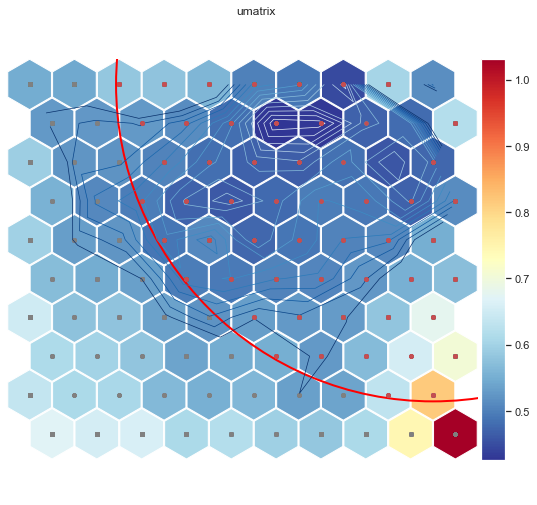

array([[0.54794535, 0.54438526, 0.58291053, 0.57815724, 0.55886874,
        0.50005792, 0.48852421, 0.44651408, 0.60154969, 0.51564699],
       [0.52786127, 0.52403035, 0.52597539, 0.51272368, 0.48168933,
        0.42618374, 0.43022107, 0.46922617, 0.47883858, 0.61909392],
       [0.59234929, 0.52225263, 0.51955127, 0.5025318 , 0.48133564,
        0.47049936, 0.46547225, 0.48461826, 0.45893896, 0.47375391],
       [0.55415048, 0.50859716, 0.49609187, 0.47028386, 0.46013024,
        0.47700148, 0.4957001 , 0.49195975, 0.47061293, 0.51192411],
       [0.5979483 , 0.53059148, 0.522184  , 0.4900187 , 0.50736758,
        0.47381124, 0.48945097, 0.50298922, 0.50784262, 0.55087376],
       [0.56865803, 0.54858734, 0.53294862, 0.49680276, 0.49449763,
        0.5021403 , 0.50468694, 0.52470977, 0.55200872, 0.57178049],
       [0.64866564, 0.57628513, 0.57956517, 0.53607643, 0.5185817 ,
        0.53246946, 0.5268517 , 0.52836285, 0.58102682, 0.67716231],
       [0.61147813, 0.59968597, 0.5809278

In [106]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

### Hit-Map

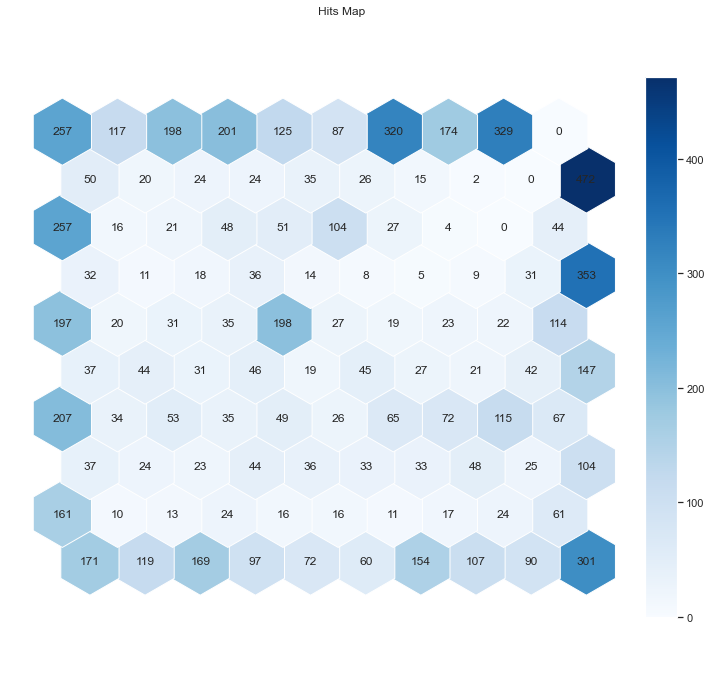

In [107]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

### K-Means on top of SOM units
- Define number of clusters to retain

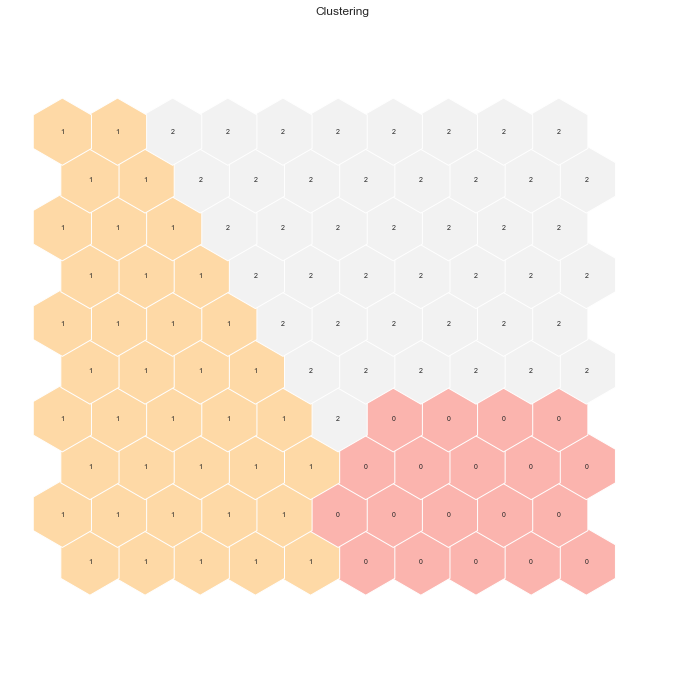

In [108]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [109]:
hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [110]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [111]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df[df_metric_features], hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.195835  0.033854  0.023532  0.002641  0.183341
3  0.281202  0.121964  0.024024  0.003551  0.290191
4  0.348100  0.122631  0.024454  0.006379  0.338911
5  0.387772  0.187095  0.120976  0.010646  0.384846
6  0.419955  0.330127  0.155043  0.010705  0.426852
7  0.445573  0.343474  0.159738  0.011863  0.451916
8  0.465782  0.359145  0.163411  0.012081  0.473084
9  0.482555  0.364268  0.237703  0.013466  0.488273

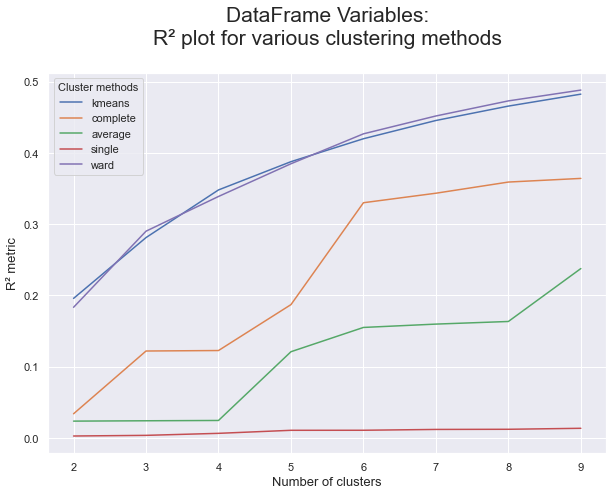

In [112]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("DataFrame Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

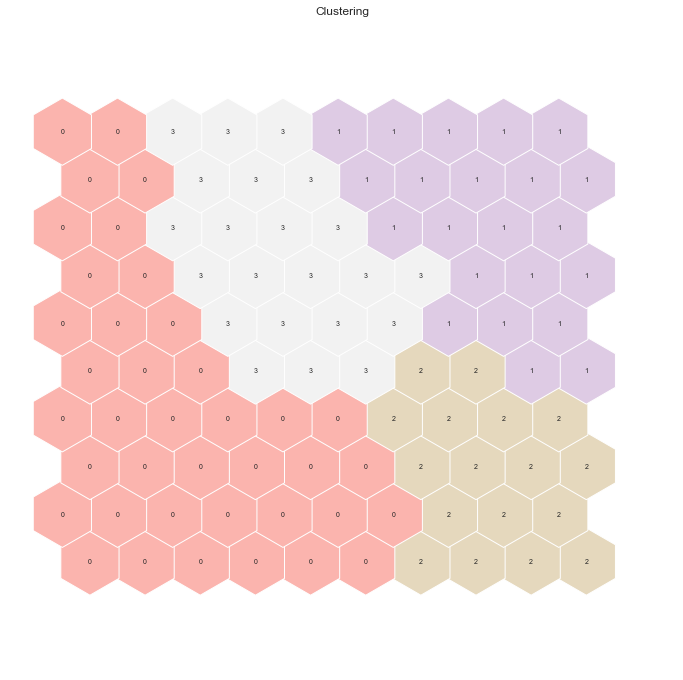

In [113]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution

In [114]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=df_metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

Salary       CMV     Motor  Household    Health      Life      Work  \
0  -0.279292  0.217163  1.224655  -0.694162 -1.104084 -0.738691 -0.705964   
1  -0.332849 -0.472782  1.232237  -0.699800 -1.105984 -0.745526 -0.711898   
2  -0.359524 -0.707970  1.150978  -0.697645 -1.011559 -0.713967 -0.692166   
3  -0.184424 -0.839257  1.076755  -0.670805 -0.945176 -0.678661 -0.667441   
4   0.159735 -0.811879  0.832654  -0.606074 -0.696364 -0.575766 -0.552767   
..       ...       ...       ...        ...       ...       ...       ...   
95 -0.109047  0.222376 -0.454544   0.824738  0.178810  0.457859  0.235140   
96  0.272871  0.662195 -0.571793   1.243331  0.166953  0.478098  0.356076   
97  0.489063  0.873027 -0.838787   1.635717  0.279971  0.644334  0.620055   
98  0.555236  0.618515 -1.054053   1.666604  0.307427  0.943358  1.126275   
99  0.456505  0.325693 -1.212369   1.650469  0.295753  1.510835  1.264229   

    Customer_Years  Salary_Rate  label  
0         0.111567    -0.211158      1  
1        -0.206850    -0.181554      1  
2         0.194784    -0.155261      1  
3         0.626016    -0.261858      1  
4         0.405227    -0.429845      1  
..             ...          ...    ...  
95       -0.153052     0.232306      0  
96       -0.046893     0.087174      0  
97        0.139900     0.062063      0  
98        0.133363     0.038251      0  
99       -0.015412     0.111030      0  

[100 rows x 10 columns]

In [115]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df[df_metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

Education    Salary  Area  Children       CMV     Motor  Household  \
CustID                                                                       
1             2.0 -0.767741   1.0       1.0  0.801633  0.299533  -0.464698   
3             1.0 -0.646860   3.0       0.0  1.358354 -1.136190   0.563164   
4             3.0 -2.070839   4.0       1.0 -0.989418 -1.336447  -0.720512   
5             3.0 -1.268189   4.0       1.0 -0.754397 -0.015446  -0.688978   
6             2.0 -0.297514   4.0       1.0 -1.022452  0.848610  -0.893771   
...           ...       ...   ...       ...       ...       ...        ...   
10290         2.0  0.829097   4.0       0.0  0.192389 -0.952854   0.889840   
10292         4.0  0.454366   2.0       0.0 -0.913448  0.450889  -0.677286   
10294         3.0  0.127987   1.0       1.0  1.445801  0.534562  -0.086646   
10295         1.0 -1.016756   2.0       1.0  0.212417 -1.284754   0.468562   
10296         4.0  0.003480   1.0       1.0  1.174191  0.622972  -0.358404   

          Health      Life      Work  Customer_Years  Salary_Rate   BMU  
CustID                                                                   
1      -0.205202  0.683456 -0.420623        0.280712     0.210228  53.0  
3      -0.494361  2.118839  2.596084       -0.645256     0.364528  99.0  
4       1.982877  0.257657 -0.000055       -0.490928     2.113170  92.0  
5       0.275801 -0.346561  0.481487        0.126384     0.614691  73.0  
6      -0.624204 -0.776373 -0.759282        0.126384    -0.391332   2.0  
...          ...       ...       ...             ...          ...   ...  
10290  -0.011898  2.621624  1.526481        0.126384    -0.331984  89.0  
10292   0.159235 -0.674941 -0.498125        0.435040    -0.615286  15.0  
10294  -0.259768 -0.569494 -0.861394       -1.108240    -0.320105  40.0  
10295   0.485302  1.299714  3.106276        0.898024     0.901077  99.0  
10296  -0.273044 -0.780387 -0.567547       -0.490928    -0.326011  40.0  

[7533 rows x 13 columns]

In [116]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

Education    Salary  Area  Children       CMV     Motor  Household  \
CustID                                                                       
1             2.0 -0.767741   1.0       1.0  0.801633  0.299533  -0.464698   
3             1.0 -0.646860   3.0       0.0  1.358354 -1.136190   0.563164   
4             3.0 -2.070839   4.0       1.0 -0.989418 -1.336447  -0.720512   
5             3.0 -1.268189   4.0       1.0 -0.754397 -0.015446  -0.688978   
6             2.0 -0.297514   4.0       1.0 -1.022452  0.848610  -0.893771   
...           ...       ...   ...       ...       ...       ...        ...   
10290         2.0  0.829097   4.0       0.0  0.192389 -0.952854   0.889840   
10292         4.0  0.454366   2.0       0.0 -0.913448  0.450889  -0.677286   
10294         3.0  0.127987   1.0       1.0  1.445801  0.534562  -0.086646   
10295         1.0 -1.016756   2.0       1.0  0.212417 -1.284754   0.468562   
10296         4.0  0.003480   1.0       1.0  1.174191  0.622972  -0.358404   

          Health      Life      Work  Customer_Years  Salary_Rate   BMU  label  
CustID                                                                          
1      -0.205202  0.683456 -0.420623        0.280712     0.210228  53.0      2  
3      -0.494361  2.118839  2.596084       -0.645256     0.364528  99.0      0  
4       1.982877  0.257657 -0.000055       -0.490928     2.113170  92.0      2  
5       0.275801 -0.346561  0.481487        0.126384     0.614691  73.0      2  
6      -0.624204 -0.776373 -0.759282        0.126384    -0.391332   2.0      1  
...          ...       ...       ...             ...          ...   ...    ...  
10290  -0.011898  2.621624  1.526481        0.126384    -0.331984  89.0      0  
10292   0.159235 -0.674941 -0.498125        0.435040    -0.615286  15.0      3  
10294  -0.259768 -0.569494 -0.861394       -1.108240    -0.320105  40.0      1  
10295   0.485302  1.299714  3.106276        0.898024     0.901077  99.0      0  
10296  -0.273044 -0.780387 -0.567547       -0.490928    -0.326011  40.0      1  

[7533 rows x 14 columns]

In [117]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

Education    Salary      Area  Children       CMV     Motor  Household  \
label                                                                           
0       2.392481  0.628597  2.740602  0.411278  0.026740 -0.853625   0.644492   
1       2.841589 -0.316587  2.693887  0.908969  0.199047  1.130749  -0.656831   
2       2.520661 -1.340057  2.709241  0.927874 -0.160716 -0.469108   0.195288   
3       2.795542  0.631068  2.694081  0.595696 -0.233113  0.277490  -0.386101   

         Health      Life      Work  Customer_Years  Salary_Rate  
label                                                             
0      0.614622  0.691030  0.630090        0.109385    -0.283126  
1     -0.998286 -0.697390 -0.678122        0.048841    -0.164162  
2      0.566656  0.124264  0.202582       -0.537771     1.441472  
3     -0.116799 -0.338729 -0.327443        0.242397    -0.613065

## Analysing the appropriateness of our solution
### R²

In [118]:
# using R²
#def get_ss(df):
    #ss = np.sum(df.var() * (df.count() - 1))
    #return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[df_metric_features])  # get total sum of squares
ssw_labels = df_final[df_metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.36009695672585695

### Density Based Clustering

### Mean Shift Clustering

In [119]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df[df_metric_features], quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

2.3064939818849974

In [120]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df[df_metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 12


In [121]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

Salary       CMV     Motor  Household    Health      Life      Work  \
CustID                                                                          
1      -0.767741  0.801633  0.299533  -0.464698 -0.205202  0.683456 -0.420623   
3      -0.646860  1.358354 -1.136190   0.563164 -0.494361  2.118839  2.596084   
4      -2.070839 -0.989418 -1.336447  -0.720512  1.982877  0.257657 -0.000055   
5      -1.268189 -0.754397 -0.015446  -0.688978  0.275801 -0.346561  0.481487   
6      -0.297514 -1.022452  0.848610  -0.893771 -0.624204 -0.776373 -0.759282   

        Customer_Years  Salary_Rate  ms_labels  
CustID                                          
1             0.280712     0.210228          0  
3            -0.645256     0.364528          8  
4            -0.490928     2.113170          0  
5             0.126384     0.614691          0  
6             0.126384    -0.391332          0

In [122]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2556


### DBSCAN (Density-based spatial clustering of applications with noise)

In [123]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[df_metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


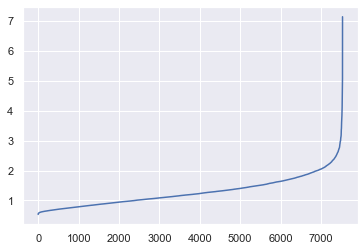

In [124]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[df_metric_features])
distances, _ = neigh.kneighbors(df[df_metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [125]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

Salary       CMV     Motor  Household    Health      Life      Work  \
CustID                                                                          
1      -0.767741  0.801633  0.299533  -0.464698 -0.205202  0.683456 -0.420623   
3      -0.646860  1.358354 -1.136190   0.563164 -0.494361  2.118839  2.596084   
4      -2.070839 -0.989418 -1.336447  -0.720512  1.982877  0.257657 -0.000055   
5      -1.268189 -0.754397 -0.015446  -0.688978  0.275801 -0.346561  0.481487   
6      -0.297514 -1.022452  0.848610  -0.893771 -0.624204 -0.776373 -0.759282   

        Customer_Years  Salary_Rate  dbscan_labels  
CustID                                              
1             0.280712     0.210228              0  
3            -0.645256     0.364528              0  
4            -0.490928     2.113170              0  
5             0.126384     0.614691              0  
6             0.126384    -0.391332              0

In [126]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

Salary       CMV     Motor  Household    Health      Life      Work  \
CustID                                                                          
17     -0.453451 -0.460285 -1.866742   3.559587  0.094313  3.550208  0.326483   
46     -1.057856  1.896939 -1.699396   2.799586  0.249248  2.840544  1.742826   
121    -1.653799  0.987102 -0.247683   2.598691 -0.700942 -0.707414  1.330705   
123    -1.564347  1.982000 -0.456400   1.059202 -1.105207  2.151312  1.481669   
139    -0.331361 -0.239711 -1.236784   1.137859 -2.148332  0.330630 -0.391973   
...          ...       ...       ...        ...       ...       ...       ...   
10116  -1.126758  3.076856 -0.920874   1.996359  0.991398 -1.031780 -0.391973   
10134  -2.652277  1.053215 -0.612494   0.952908  0.511855 -0.597954  1.669364   
10139  -1.491819  2.627743 -1.385348   1.086838  0.182867  1.834973  1.987821   
10158  -0.227403 -0.812410 -2.298305   2.421534  2.022707  2.410732  0.697832   
10178  -2.468538 -0.242682 -1.077898  -0.165304  1.279097  0.363103  0.877446   

        Customer_Years  Salary_Rate  dbscan_labels  
CustID                                              
17           -0.645256     1.357397             -1  
46           -0.645256     2.045804             -1  
121          -0.336600     3.295888             -1  
123          -1.571224     2.039247             -1  
139           1.206680    -0.477944             -1  
...                ...          ...            ...  
10116        -0.645256     1.629688             -1  
10134        -0.645256     8.452181             -1  
10139        -0.953912     1.858980             -1  
10158         0.435040     0.840090             -1  
10178        -1.416896     4.806732             -1  

[218 rows x 10 columns]

In [127]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1124


### GMM (Gaussian Mixture Model )

In [128]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[df_metric_features])
labels_proba = gmm.predict_proba(df[df_metric_features])

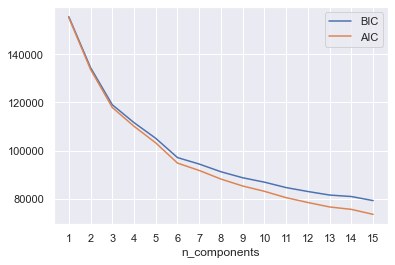

In [129]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[df_metric_features])
          for n in n_components]

bic_values = [m.bic(df[df_metric_features]) for m in models]
aic_values = [m.aic(df[df_metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [130]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=6, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[df_metric_features])

In [131]:
# Concatenating the labels to df
df_concat = pd.concat([df[df_metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

Salary       CMV     Motor  Household    Health      Life      Work  \
CustID                                                                          
1      -0.767741  0.801633  0.299533  -0.464698 -0.205202  0.683456 -0.420623   
3      -0.646860  1.358354 -1.136190   0.563164 -0.494361  2.118839  2.596084   
4      -2.070839 -0.989418 -1.336447  -0.720512  1.982877  0.257657 -0.000055   
5      -1.268189 -0.754397 -0.015446  -0.688978  0.275801 -0.346561  0.481487   
6      -0.297514 -1.022452  0.848610  -0.893771 -0.624204 -0.776373 -0.759282   

        Customer_Years  Salary_Rate  gmm_labels  
CustID                                           
1             0.280712     0.210228           1  
3            -0.645256     0.364528           4  
4            -0.490928     2.113170           4  
5             0.126384     0.614691           1  
6             0.126384    -0.391332           5

In [132]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[df_metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3258


### Testing on K-means and Hierarchical clustering


In [133]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [134]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(demo_df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        demo_df, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.413656  0.216313  0.392466  0.000374  0.377226
3  0.551759  0.445920  0.393375  0.015609  0.497032
4  0.638627  0.501062  0.427655  0.020044  0.568871
5  0.683398  0.622993  0.433607  0.023436  0.618942
6  0.714096  0.645936  0.508013  0.036114  0.665061
7  0.743144  0.665337  0.614375  0.062642  0.690492
8  0.761540  0.673727  0.615882  0.068149  0.715875
9  0.782058  0.690127  0.630449  0.092272  0.735063

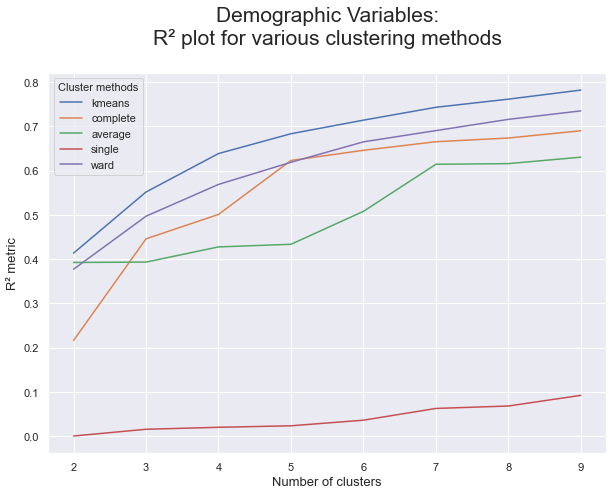

In [135]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat Process For Insurance

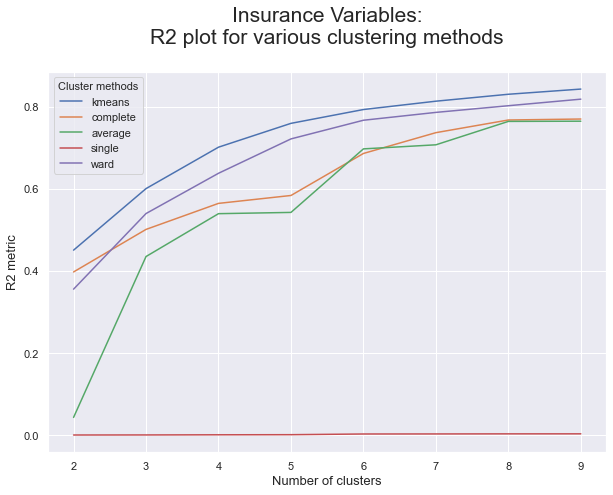

In [136]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(insurance_df, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        insurance_df, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Insurance Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

In [137]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
insurance_labels = kmeans_prod.fit_predict(insurance_df)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
demo_labels = kmeans_behav.fit_predict(demo_df)

df['insurance_labels'] = insurance_labels
df['demo_labels'] = demo_labels

In [138]:
# Count label frequencies (contigency table)
df.groupby(['insurance_labels', 'demo_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('demo_labels', 'insurance_labels', 0)

insurance_labels    0    1    2    3
demo_labels                         
0                 564  812  210  820
1                 491  326  193  324
2                 789  493  299  562
3                 375  544  138  593

### Merging using Hierarchical Clustering

In [139]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demo_labels', 'insurance_labels'])\
    [df_metric_features].mean()
df_centroids

Salary       CMV     Motor  Household  \
demo_labels insurance_labels                                            
0           0                -0.982825 -0.430054 -0.841442   0.571533   
            1                -0.686960  1.011561  0.735397  -0.554858   
            2                -0.987428  1.284787 -0.819037   1.442668   
            3                -0.683204 -0.982287  0.746657  -0.609091   
1           0                 1.001959 -0.419175 -0.975177   0.556450   
            1                 0.820480  0.900163  0.464893  -0.455142   
            2                 0.983092  1.323052 -1.013494   1.607347   
            3                 0.829892 -0.952226  0.453693  -0.547394   
2           0                 0.951867 -0.418648 -0.945669   0.509477   
            1                 0.786806  0.921488  0.461948  -0.432316   
            2                 0.898973  1.274311 -0.910755   1.546345   
            3                 0.829757 -0.980307  0.380015  -0.580212   
3           0                -0.938027 -0.407583 -0.926308   0.590649   
            1                -0.673505  0.992025  0.736140  -0.591654   
            2                -0.874380  1.256445 -0.789919   1.584966   
            3                -0.629970 -0.998159  0.752258  -0.634891   

                                Health      Life      Work  Customer_Years  \
demo_labels insurance_labels                                                 
0           0                 0.629808  0.534155  0.562793       -0.311700   
            1                -0.579254 -0.459642 -0.472174        0.015769   
            2                 0.301348  0.638502  0.659740       -0.265315   
            3                -0.571022 -0.473543 -0.448028        0.036610   
1           0                 0.895903  0.493652  0.460562        0.100296   
            1                -0.313620 -0.317200 -0.293535        0.143900   
            2                 0.483890  0.822305  0.680885       -0.049534   
            3                -0.283210 -0.288357 -0.248257        0.099234   
2           0                 0.898160  0.580044  0.511224        0.141054   
            1                -0.332295 -0.289141 -0.291529        0.107602   
            2                 0.409878  0.613168  0.694789        0.075285   
            3                -0.188416 -0.274977 -0.236067        0.087939   
3           0                 0.664130  0.662878  0.607045       -0.242769   
            1                -0.562005 -0.478000 -0.488754       -0.076739   
            2                 0.233461  0.586687  0.711077       -0.192337   
            3                -0.600686 -0.491545 -0.474171       -0.011809   

                              Salary_Rate  
demo_labels insurance_labels               
0           0                    1.118927  
            1                    0.187772  
            2                    1.627363  
            3                    0.160443  
1           0                   -0.533178  
            1                   -0.702172  
            2                   -0.243552  
            3                   -0.731322  
2           0                   -0.508539  
            1                   -0.685853  
            2                   -0.218485  
            3                   -0.739154  
3           0                    1.033927  
            1                    0.154599  
            2                    1.555826  
            3                    0.086617

In [140]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

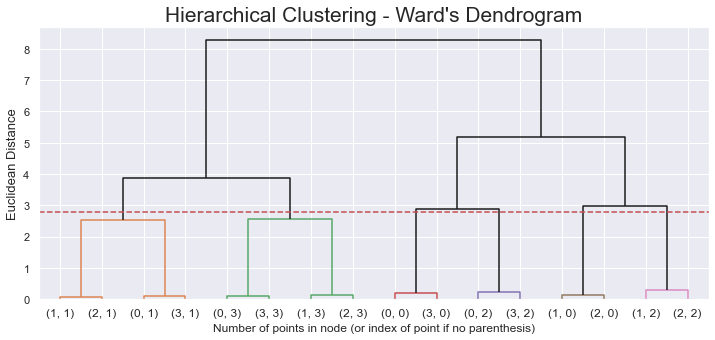

In [141]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(12,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.8
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [142]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Salary       CMV     Motor  Household  \
demo_labels insurance_labels                                            
0           0                -0.982825 -0.430054 -0.841442   0.571533   
            1                -0.686960  1.011561  0.735397  -0.554858   
            2                -0.987428  1.284787 -0.819037   1.442668   
            3                -0.683204 -0.982287  0.746657  -0.609091   
1           0                 1.001959 -0.419175 -0.975177   0.556450   
            1                 0.820480  0.900163  0.464893  -0.455142   
            2                 0.983092  1.323052 -1.013494   1.607347   
            3                 0.829892 -0.952226  0.453693  -0.547394   
2           0                 0.951867 -0.418648 -0.945669   0.509477   
            1                 0.786806  0.921488  0.461948  -0.432316   
            2                 0.898973  1.274311 -0.910755   1.546345   
            3                 0.829757 -0.980307  0.380015  -0.580212   
3           0                -0.938027 -0.407583 -0.926308   0.590649   
            1                -0.673505  0.992025  0.736140  -0.591654   
            2                -0.874380  1.256445 -0.789919   1.584966   
            3                -0.629970 -0.998159  0.752258  -0.634891   

                                Health      Life      Work  Customer_Years  \
demo_labels insurance_labels                                                 
0           0                 0.629808  0.534155  0.562793       -0.311700   
            1                -0.579254 -0.459642 -0.472174        0.015769   
            2                 0.301348  0.638502  0.659740       -0.265315   
            3                -0.571022 -0.473543 -0.448028        0.036610   
1           0                 0.895903  0.493652  0.460562        0.100296   
            1                -0.313620 -0.317200 -0.293535        0.143900   
            2                 0.483890  0.822305  0.680885       -0.049534   
            3                -0.283210 -0.288357 -0.248257        0.099234   
2           0                 0.898160  0.580044  0.511224        0.141054   
            1                -0.332295 -0.289141 -0.291529        0.107602   
            2                 0.409878  0.613168  0.694789        0.075285   
            3                -0.188416 -0.274977 -0.236067        0.087939   
3           0                 0.664130  0.662878  0.607045       -0.242769   
            1                -0.562005 -0.478000 -0.488754       -0.076739   
            2                 0.233461  0.586687  0.711077       -0.192337   
            3                -0.600686 -0.491545 -0.474171       -0.011809   

                              Salary_Rate  hclust_labels  
demo_labels insurance_labels                              
0           0                    1.118927              5  
            1                    0.187772              1  
            2                    1.627363              3  
            3                    0.160443              0  
1           0                   -0.533178              4  
            1                   -0.702172              1  
            2                   -0.243552              2  
            3                   -0.731322              0  
2           0                   -0.508539              4  
            1                   -0.685853              1  
            2                   -0.218485              2  
            3                   -0.739154              0  
3           0                    1.033927              5  
            1                    0.154599              1  
            2                    1.555826              3  
            3                    0.086617              0

In [143]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demo_labels'], row['insurance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[df_metric_features]

Salary       CMV     Motor  Household    Health      Life  \
merged_labels                                                                
0             -0.086381 -0.981660  0.617187  -0.599991 -0.444582 -0.403548   
1             -0.123598  0.969561  0.633057  -0.521339 -0.479148 -0.404237   
2              0.931971  1.293431 -0.951057   1.570275  0.438911  0.695208   
3             -0.942599  1.273548 -0.807490   1.499096  0.274427  0.617955   
4              0.971082 -0.418850 -0.956988   0.527495  0.897294  0.546905   
5             -0.964935 -0.421080 -0.875334   0.579167  0.643515  0.585562   

                   Work  Customer_Years  Salary_Rate  
merged_labels                                         
0             -0.374803        0.045494    -0.204187  
1             -0.408600        0.032652    -0.151936  
2              0.689335        0.026322    -0.228319  
3              0.680098       -0.236376     1.598995  
4              0.491790        0.125419    -0.517990  
5              0.580466       -0.284171     1.084981

In [144]:
df = df_.copy()

In [145]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['demo_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('demo_labels', 'insurance_labels', 0)

insurance_labels       0       1      2       3
demo_labels                                    
2                 1280.0     NaN  492.0     NaN
3                  939.0  2175.0  348.0  2299.0

### Cluster Analysis

In [146]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

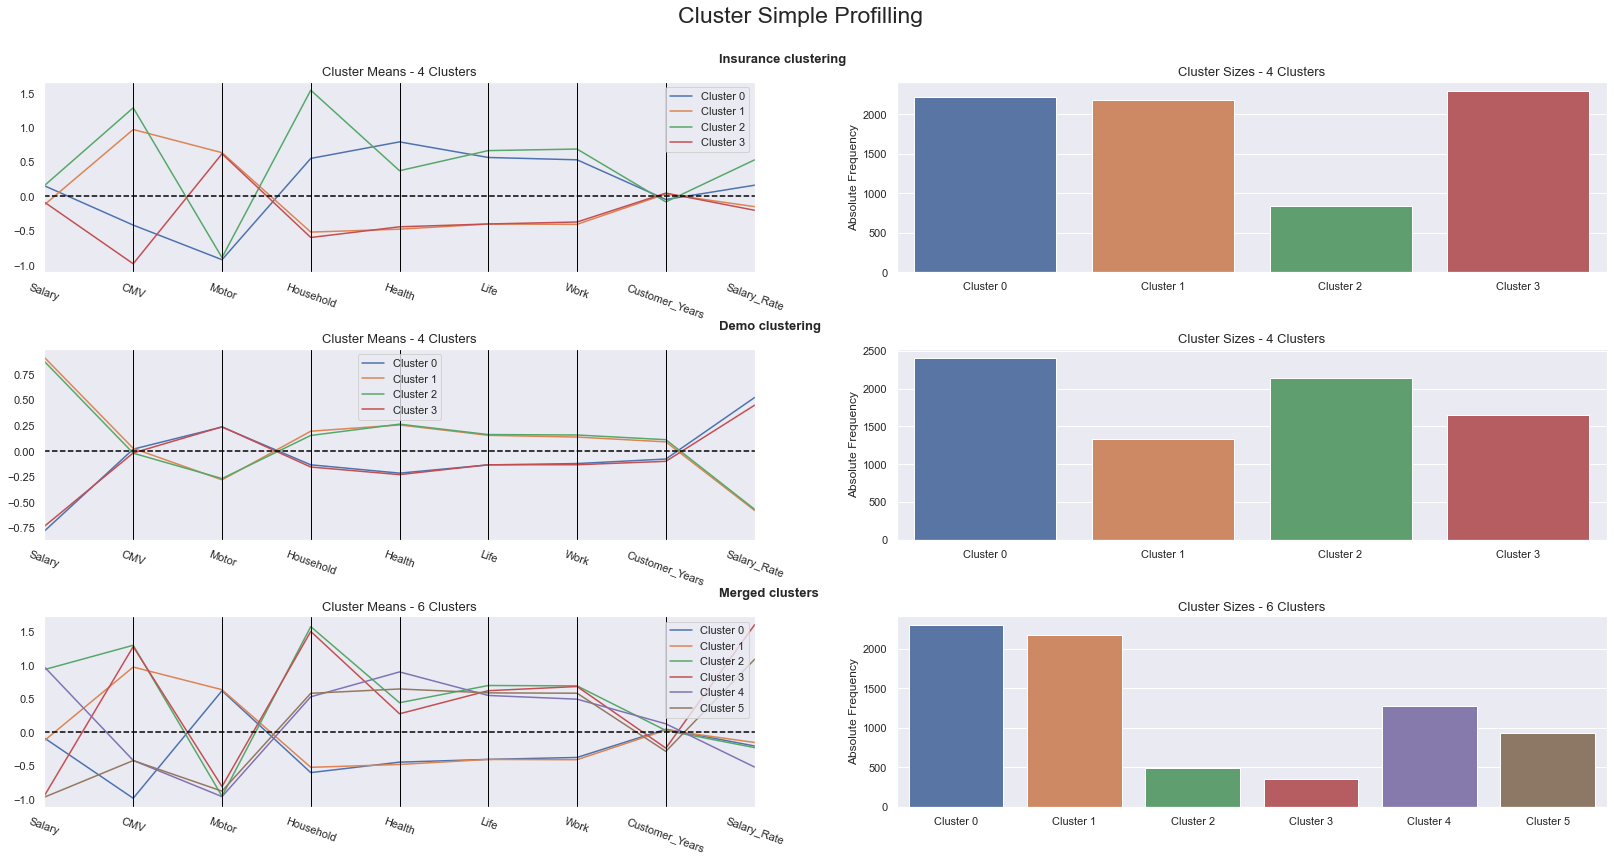

In [147]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[df_metric_features + ['insurance_labels', 'demo_labels', 'merged_labels']], 
    label_columns = ['insurance_labels', 'demo_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Insurance clustering", "Demo clustering", "Merged clusters"]
)

### Cluster Visualization using t-SNE

In [148]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[df_metric_features])

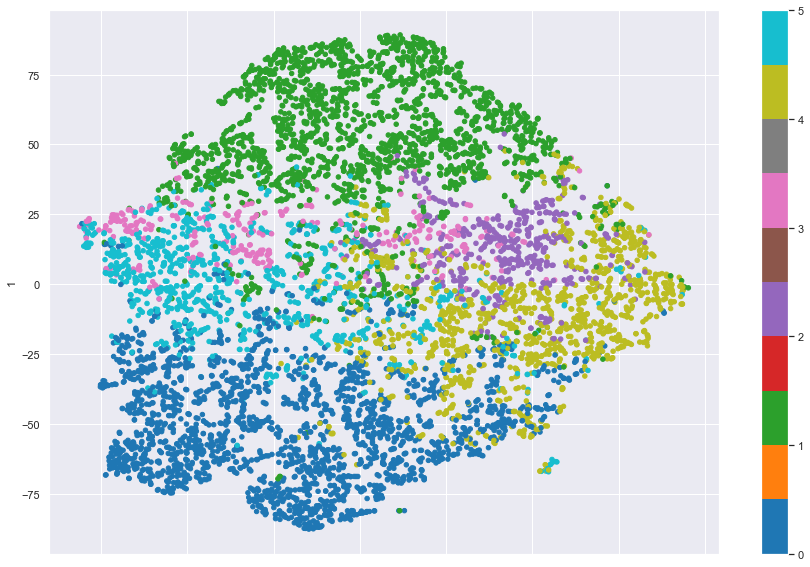

In [149]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()